# Simulated active learning loop based on ConvNeXt


<b> What are we doing here? <b>

1. Load the pretrained ConvNeXt backbone (red) from Hugging Face
2. Load the fine-tuned classification model (blue) and extract its weights, especially the ConvNeXt backbone
3. Create a new regression model (orange) by modifying ConvNextWithCustomFC to have a regression head instead of a classification head
4. Transfer the pretrained weights from the blue model to the orange model while ensuring the ConvNeXt backbone remains unchanged and that the new regression head is properly initialized
5. Verify that the weights have been correctly loaded, particularly ensuring that the ConvNeXt backbone remains the same.

In [1]:
!pip install numpy==1.26.4 torch==2.1.0 torchvision==0.16.0 \
    transformers==4.48.1 pillow==9.2.0 anndata==0.10.3 scanpy==1.9.6 \
    matplotlib gputil leidenalg umap-learn h5py requests \
    "scikit-learn>=0.24" statsmodels==0.14.4 session-info patsy \
    safetensors==0.5.2 tokenizers==0.21.0 huggingface-hub==0.27.1 \
    llvmlite==0.44.0 numba==0.61.0 stdlib-list==0.11.0

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 18.2 MB 3.2 MB/s eta 0:00:01
     |██████████████▏                 | 295.9 MB 196.7 MB/s eta 0:00:02

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 670.2 MB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 147.9 MB/s eta 0:00:01
     |████████████████████████████████| 9.7 MB 159.2 MB/s eta 0:00:01
     |████████████████████████████████| 119 kB 122.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 157.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 112.8 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 155.7 MB/s eta 0:00:01
     |████████████████████████████████| 10.8 MB 150.6 MB/s eta 0:00:01
     |████████████████████████████████| 232 kB 147.5 MB/s eta 0:00:01
     |████████████████████████████████| 461 kB 108.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 144.9 MB/s eta 0:00:01
     |████████████████████████████████| 450 kB 146.1 MB/s eta 0:00:01
     |████████████████████████████████| 42.4 MB 157.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 94.2 MB/s eta 0:00:01
     |██████████████

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 209.8 MB 208.4 MB/s eta 0:00:01
     |████████████████████████████████| 99 kB 114.4 MB/s eta 0:00:01
     |████████████████████████████████| 121.6 MB 153.9 MB/s eta 0:00:01
     |████████████████████████████████| 23.7 MB 156.7 MB/s eta 0:00:01
     |████████████████████████████████| 196.0 MB 206.7 MB/s eta 0:00:01
     |████████████████████████████████| 823 kB 145.2 MB/s eta 0:00:01
     |████████████████████████████████| 124.2 MB 145.7 MB/s eta 0:00:01
     |████████████████████████████████| 14.1 MB 150.1 MB/s eta 0:00:01
     |████████████████████████████████| 731.7 MB 48.0 MB/s eta 0:00:014
     |████████████████████████████████| 56.5 MB 142.9 MB/s eta 0:00:01
     |████████████████████████████████| 53 kB 87.2 MB/s  eta 0:00:01
     |████████████████████████████████| 39.3 MB 139.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 129.0 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 117.1 MB/s eta 0:00:01
  Created

In [101]:
# Standard library imports
import os
import re
import glob
import random
#import pandas as pd
import pickle
from collections import Counter

# Third-party imports
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms, utils
import numpy as np
import h5py
import umap
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
import requests

# Transformers library imports
from transformers import AutoImageProcessor, ConvNextModel, ConvNextConfig
from sklearn.neighbors import NearestNeighbors

# Project-specific imports
from sparcscore.ml.datasets import HDF5SingleCellDataset
from sparcscore.ml.transforms import RandomRotation, GaussianNoise, ChannelReducer, ChannelSelector
from sparcscore.ml.utils import combine_datasets_balanced
from sparcscore.ml.pretrained_models import autophagy_classifier2_1

In [2]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load configuration for ConvNext
config = ConvNextConfig.from_pretrained("facebook/convnext-xlarge-224-22k")

# Load the pretrained ConvNext model (red!)
original_model = ConvNextModel.from_pretrained("facebook/convnext-xlarge-224-22k")
original_model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


ConvNextModel(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            

In [2]:
# model with a classification head (blue!)
class ConvNextWithCustomFC(ConvNextModel):
    def __init__(self, config, num_classes=2):
        super().__init__(config)
        # FC layer for classification
        self.fc = nn.Linear(config.hidden_sizes[-1], num_classes)

    def forward(self, pixel_values, **kwargs):
        outputs = super().forward(pixel_values, **kwargs)
        
        # Extracct the pooled output
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
            embeddings = outputs.pooler_output
        else:
            # Perform mean pooling across the spatial dimensions
            embeddings = outputs.last_hidden_state.mean(dim=1)
        
        # Pass embedings through classification head
        logits = self.fc(embeddings)
        return logits

In [28]:
# Load the fine-tuned classification model (Blue)
classification_model = ConvNextWithCustomFC.from_pretrained(
    "facebook/convnext-xlarge-224-22k", config=config, num_classes=3
)
classification_model.to(device)

Some weights of ConvNextWithCustomFC were not initialized from the model checkpoint at facebook/convnext-xlarge-224-22k and are newly initialized: ['convnext.fc.bias', 'convnext.fc.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ConvNextWithCustomFC(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
     

In [5]:
# backbone weights (everything exept classification head)
backbone_weights = {name: param.clone().detach() for name, param in classification_model.named_parameters() if "fc" not in name}

In [3]:
class ConvNextWithRegressionHead(ConvNextModel):
    def __init__(self, config, output_dim=1): 
        super().__init__(config)
        self.regression_head = nn.Linear(config.hidden_sizes[-1], output_dim)

    def forward(self, pixel_values, **kwargs):
        outputs = super().forward(pixel_values, **kwargs)

        # Extract the pooled output
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
            embeddings = outputs.pooler_output
        else:
            embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
        
        # Pass embeddings through regression head
        regression_output = self.regression_head(embeddings)
        return regression_output

In [7]:
# Initialize regression model (Orange)
regression_model = ConvNextWithRegressionHead.from_pretrained(
    "facebook/convnext-xlarge-224-22k", config=config, output_dim=6  
)
regression_model.to(device)

# Load backbone weights from the classification model
with torch.no_grad():
    for name, param in regression_model.named_parameters():
        if name in backbone_weights:
            param.copy_(backbone_weights[name]) 

Some weights of ConvNextWithRegressionHead were not initialized from the model checkpoint at facebook/convnext-xlarge-224-22k and are newly initialized: ['convnext.regression_head.bias', 'convnext.regression_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Check if backbone weights are the same
for name, param in regression_model.named_parameters():
    if name in backbone_weights:
        if torch.equal(param, backbone_weights[name]):
            print(f"Backbone weights for {name} are unchanged.")
        else:
            print(f"Backbone weights for {name} have changed!")


Backbone weights for embeddings.patch_embeddings.weight are unchanged.
Backbone weights for embeddings.patch_embeddings.bias are unchanged.
Backbone weights for embeddings.layernorm.weight are unchanged.
Backbone weights for embeddings.layernorm.bias are unchanged.
Backbone weights for encoder.stages.0.layers.0.layer_scale_parameter are unchanged.
Backbone weights for encoder.stages.0.layers.0.dwconv.weight are unchanged.
Backbone weights for encoder.stages.0.layers.0.dwconv.bias are unchanged.
Backbone weights for encoder.stages.0.layers.0.layernorm.weight are unchanged.
Backbone weights for encoder.stages.0.layers.0.layernorm.bias are unchanged.
Backbone weights for encoder.stages.0.layers.0.pwconv1.weight are unchanged.
Backbone weights for encoder.stages.0.layers.0.pwconv1.bias are unchanged.
Backbone weights for encoder.stages.0.layers.0.pwconv2.weight are unchanged.
Backbone weights for encoder.stages.0.layers.0.pwconv2.bias are unchanged.
Backbone weights for encoder.stages.0.la

### Preprocess, normalize the ground truth and get output_dim for orange model

In [22]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA


base_dir = "/dss/dsshome1/0F/di93quv/Niklas_inputs/simulated_active_learning/sequencing_data_gRNA_count_tables"
save_path = "/dss/dsshome1/0F/di93quv/Niklas_inputs/simulated_active_learning/final_df.csv"

# Cutoff values per bin
cutoffs = {
    'plate1_bin3.1': 150, 'plate1_bin3.2': 150, 'plate1_bin3.3': 150, 'plate1_bin3.4': 150,
    'plate1_bin4.1': 150, 'plate1_bin4.2': 150, 'plate1_bin4.3': 150, 'plate1_bin5.1': 150,
    'plate1_bin5.2': 150, 'plate1_bin5.3': 150, 'plate1_bin6.1': 150, 'plate1_bin6.2': 150,
    'plate1_bin6.3': 100, 'plate2_bin3.1': 150, 'plate2_bin3.2': 150, 'plate2_bin3.3': 150,
    'plate2_bin3.4': 150, 'plate2_bin4.1': 150, 'plate2_bin4.2': 150, 'plate2_bin4.3': 150,
    'plate2_bin5.1': 150, 'plate2_bin5.2': 150, 'plate2_bin5.3': 150, 'plate2_bin6.1': 150,
    'plate2_bin6.2': 150, 'plate2_bin6.3': 100, 'plate3_bin3.1': 125, 'plate3_bin3.2': 125,
    'plate3_bin3.3': 125, 'plate3_bin3.4': 125, 'plate3_bin4.1': 125, 'plate3_bin4.2': 125,
    'plate3_bin4.3': 125, 'plate3_bin5.1': 100, 'plate3_bin5.2': 125, 'plate3_bin5.3': 125,
    'plate3_bin6.1': 125, 'plate3_bin6.2': 100, 'plate3_bin6.3': 125, 'plate5_bin3.1': 50,
    'plate5_bin3.2': 50, 'plate5_bin3.3': 50, 'plate5_bin3.4': 50, 'plate5_bin4.1': 50,
    'plate5_bin4.2': 50, 'plate5_bin4.3': 50, 'plate5_bin5.1': 50, 'plate5_bin5.2': 50,
    'plate5_bin5.3': 100, 'plate5_bin6.1': 100, 'plate5_bin6.2': 100, 'plate5_bin6.3': 100
}

# Contaminated samples
contaminated_samples = {"plate1_bin3.1", "plate1_bin3.2", "plate1_bin3.3", "plate1_bin3.4", 
                        "plate1_bin4.1", "plate1_bin4.2", "plate1_bin4.3", "plate1_bin5.1", 
                        "plate1_bin5.2", "plate1_bin5.3", "plate1_bin6.1", "plate1_bin6.2",
                        "plate1_bin6.3", "plate5_bin3.1", "plate5_bin3.2", "plate5_bin3.3",
                        "plate5_bin3.4", "plate5_bin4.1", "plate5_bin4.2", "plate5_bin4.3",
                        "plate5_bin5.1", "plate5_bin5.2", "plate5_bin5.3", "plate5_bin6.1",
                        "plate5_bin6.2", "plate5_bin6.3"}

# Special mappings for bins 1 & 2
bin_mapping = {
    'C1': 'bin1', 'C2': 'bin2', 'C3': 'bin2', 'C4': 'bin2',
}

# Init. bin-level data storage
bin_data = {}

# Process each subdirectory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        bin_id = subdir.split('_bin')[-1].split('.')[0]  # Gett bin number
        bin_id = f'bin{bin_id}' if bin_id.isdigit() else bin_mapping.get(subdir.split('_')[-1], None)
        if bin_id is None:
            continue  # Skip unknown bins

        if bin_id not in bin_data:
            bin_data[bin_id] = {}

        #Read all gRNA count files in the subdir
        total_reads = 0
        gRNA_counts = {}
        for file in os.listdir(subdir_path):
            if file.startswith('grna_counts_') and file.endswith('.csv'):
                file_path = os.path.join(subdir_path, file)
                df = pd.read_csv(file_path, names=['gRNA', 'Count'], sep="\t").dropna(subset=['gRNA'])

                # Remove contaminated gRNA
                if subdir in contaminated_samples:
                    df = df[df['gRNA'] != "TACGTCATTAAGAGTTCAAC"]

                # Convert counts to numeric!
                df['Count'] = pd.to_numeric(df['Count'], errors='coerce').fillna(0)
                total_reads += df['Count'].sum()

                # Sum counts
                for _, row in df.iterrows():
                    gRNA = row['gRNA'].strip()
                    gRNA_counts[gRNA] = gRNA_counts.get(gRNA, 0) + row['Count']

        # Normalize by total reads
        if total_reads > 0:
            for gRNA in gRNA_counts:
                gRNA_counts[gRNA] /= total_reads 

        # Apply cutoffs
        cutoff = cutoffs.get(subdir, 0)
        gRNA_counts = {gRNA: count for gRNA, count in gRNA_counts.items() if count >= cutoff}

        # Aggregate into bin-level data
        for gRNA, count in gRNA_counts.items():
            bin_data[bin_id][gRNA] = bin_data[bin_id].get(gRNA, 0) + count  # Sum across subbins

# Convert bin-level dictionary to DataFrame
final_df = pd.DataFrame.from_dict(bin_data, orient='index').fillna(0)
final_df

GACAAACCATATACCTACGA  GTAGCCCAGGTACATGACCG  CACCGTACAGATCAACGTGA  \
bin5              0.005573          3.956088e-03          2.297496e-03   
bin6              0.000002          8.226674e-07          9.330594e-07   
bin1              0.000000          2.197358e-06          0.000000e+00   
bin3              0.000000          0.000000e+00          0.000000e+00   
bin2              0.000000          0.000000e+00          0.000000e+00   
bin4              0.000000          0.000000e+00          0.000000e+00   

      GATGTATGATGGCACCAAGG  TTCAATCACCTCACGGTAAG  AGATGCCCCTCCATCCGGAG  \
bin5              0.002006              0.002025          1.891505e-03   
bin6              0.000002              0.000000          4.113337e-07   
bin1              0.000000              0.000000          4.482610e-04   
bin3              0.000000              0.000000          0.000000e+00   
bin2              0.000000              0.000000          0.000000e+00   
bin4              0.000000              0.000000          0.000000e+00   

      GGATTCGCTCATGTACTGTG  AATTGAGCGCAATACATGCA  TGTATTCCAGGATACACGGG  \
bin5              0.001809              0.001804              0.001759   
bin6              0.000578              0.000180              0.000000   
bin1              0.000000              0.000000              0.000000   
bin3              0.000116              0.000000              0.000000   
bin2              0.000262              0.000000              0.000000   
bin4              0.000000              0.000000              0.000000   

      GGAGGCTGAAACGAGAGACC  ...  ATGCAGCTGGTGAGTCTCAT  AGGATAAGTTCCTAAGCGAG  \
bin5          1.736588e-03  ...          0.000000e+00          0.000000e+00   
bin6          8.226674e-07  ...          0.000000e+00          0.000000e+00   
bin1          0.000000e+00  ...          0.000000e+00          0.000000e+00   
bin3          4.704572e-04  ...          0.000000e+00          0.000000e+00   
bin2          0.000000e+00  ...          9.522467e-07          9.522467e-07   
bin4          0.000000e+00  ...          0.000000e+00          0.000000e+00   

      AATGATCCGTAAAAGACAAG  TGCTGATGAACTCCAGAAGA  GCGAGTACCTTACCGAGGAA  \
bin5          0.000000e+00          0.000000e+00          0.000000e+00   
bin6          0.000000e+00          0.000000e+00          0.000000e+00   
bin1          0.000000e+00          0.000000e+00          0.000000e+00   
bin3          0.000000e+00          0.000000e+00          0.000000e+00   
bin2          9.522467e-07          9.522467e-07          9.522467e-07   
bin4          0.000000e+00          0.000000e+00          0.000000e+00   

      AGGTGTTATCCACGTGACCA  GGGGCCGATACCCCGAACGA  CCTCTGCGTCGAGGGAACCG  \
bin5          0.000000e+00          0.000000e+00          0.000000e+00   
bin6          0.000000e+00          0.000000e+00          0.000000e+00   
bin1          0.000000e+00          0.000000e+00          0.000000e+00   
bin3          0.000000e+00          0.000000e+00          0.000000e+00   
bin2          9.522467e-07          9.522467e-07          9.522467e-07   
bin4          0.000000e+00          0.000000e+00          0.000000e+00   

      GTGTGGCTGAAAGACAGCGG  GCATGTGTCACAGCTGACTT  
bin5          0.000000e+00          0.000000e+00  
bin6          0.000000e+00          0.000000e+00  
bin1          0.000000e+00          0.000000e+00  
bin3          0.000000e+00          0.000000e+00  
bin2          9.522467e-07          9.522467e-07  
bin4          0.000000e+00          0.000000e+00  

[6 rows x 35260 columns]

In [23]:
# Ensure the bins are sorted correctly
final_df = final_df.reindex(['bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6'])
final_df

GACAAACCATATACCTACGA  GTAGCCCAGGTACATGACCG  CACCGTACAGATCAACGTGA  \
bin1              0.000000          2.197358e-06          0.000000e+00   
bin2              0.000000          0.000000e+00          0.000000e+00   
bin3              0.000000          0.000000e+00          0.000000e+00   
bin4              0.000000          0.000000e+00          0.000000e+00   
bin5              0.005573          3.956088e-03          2.297496e-03   
bin6              0.000002          8.226674e-07          9.330594e-07   

      GATGTATGATGGCACCAAGG  TTCAATCACCTCACGGTAAG  AGATGCCCCTCCATCCGGAG  \
bin1              0.000000              0.000000          4.482610e-04   
bin2              0.000000              0.000000          0.000000e+00   
bin3              0.000000              0.000000          0.000000e+00   
bin4              0.000000              0.000000          0.000000e+00   
bin5              0.002006              0.002025          1.891505e-03   
bin6              0.000002              0.000000          4.113337e-07   

      GGATTCGCTCATGTACTGTG  AATTGAGCGCAATACATGCA  TGTATTCCAGGATACACGGG  \
bin1              0.000000              0.000000              0.000000   
bin2              0.000262              0.000000              0.000000   
bin3              0.000116              0.000000              0.000000   
bin4              0.000000              0.000000              0.000000   
bin5              0.001809              0.001804              0.001759   
bin6              0.000578              0.000180              0.000000   

      GGAGGCTGAAACGAGAGACC  ...  ATGCAGCTGGTGAGTCTCAT  AGGATAAGTTCCTAAGCGAG  \
bin1          0.000000e+00  ...          0.000000e+00          0.000000e+00   
bin2          0.000000e+00  ...          9.522467e-07          9.522467e-07   
bin3          4.704572e-04  ...          0.000000e+00          0.000000e+00   
bin4          0.000000e+00  ...          0.000000e+00          0.000000e+00   
bin5          1.736588e-03  ...          0.000000e+00          0.000000e+00   
bin6          8.226674e-07  ...          0.000000e+00          0.000000e+00   

      AATGATCCGTAAAAGACAAG  TGCTGATGAACTCCAGAAGA  GCGAGTACCTTACCGAGGAA  \
bin1          0.000000e+00          0.000000e+00          0.000000e+00   
bin2          9.522467e-07          9.522467e-07          9.522467e-07   
bin3          0.000000e+00          0.000000e+00          0.000000e+00   
bin4          0.000000e+00          0.000000e+00          0.000000e+00   
bin5          0.000000e+00          0.000000e+00          0.000000e+00   
bin6          0.000000e+00          0.000000e+00          0.000000e+00   

      AGGTGTTATCCACGTGACCA  GGGGCCGATACCCCGAACGA  CCTCTGCGTCGAGGGAACCG  \
bin1          0.000000e+00          0.000000e+00          0.000000e+00   
bin2          9.522467e-07          9.522467e-07          9.522467e-07   
bin3          0.000000e+00          0.000000e+00          0.000000e+00   
bin4          0.000000e+00          0.000000e+00          0.000000e+00   
bin5          0.000000e+00          0.000000e+00          0.000000e+00   
bin6          0.000000e+00          0.000000e+00          0.000000e+00   

      GTGTGGCTGAAAGACAGCGG  GCATGTGTCACAGCTGACTT  
bin1          0.000000e+00          0.000000e+00  
bin2          9.522467e-07          9.522467e-07  
bin3          0.000000e+00          0.000000e+00  
bin4          0.000000e+00          0.000000e+00  
bin5          0.000000e+00          0.000000e+00  
bin6          0.000000e+00          0.000000e+00  

[6 rows x 35260 columns]

In [24]:
# Check if normalization is correct (should sum to ~1.0)
print(final_df.sum(axis=1))

# Check if PCA was applied (should be 6 rows, 300 columns if needed)
print(final_df.shape)

bin1    3.0
bin2    3.0
bin3    4.0
bin4    3.0
bin5    3.0
bin6    3.0
dtype: float64
(6, 35260)


In [25]:
# Save the final DataFrame
final_df.to_csv(save_path)
print(f"[INFO] Final dataframe saved to {save_path}")

[INFO] Final dataframe saved to /dss/dsshome1/0F/di93quv/Niklas_inputs/simulated_active_learning/final_df.csv


In [4]:
import pandas as pd

# Load the DataFrame from CSV
file_path = "/dss/dsshome1/0F/di93quv/Niklas_inputs/simulated_active_learning/final_df.csv"
final_df = pd.read_csv(file_path, index_col=0)  # Ensure the first column is used as the index

# Display basic info
print(final_df.shape)  # Should be (6, 35260)
final_df 

(6, 35260)


GACAAACCATATACCTACGA  GTAGCCCAGGTACATGACCG  CACCGTACAGATCAACGTGA  \
bin1              0.000000          2.197358e-06          0.000000e+00   
bin2              0.000000          0.000000e+00          0.000000e+00   
bin3              0.000000          0.000000e+00          0.000000e+00   
bin4              0.000000          0.000000e+00          0.000000e+00   
bin5              0.005573          3.956088e-03          2.297496e-03   
bin6              0.000002          8.226674e-07          9.330594e-07   

      GATGTATGATGGCACCAAGG  TTCAATCACCTCACGGTAAG  AGATGCCCCTCCATCCGGAG  \
bin1              0.000000              0.000000          4.482610e-04   
bin2              0.000000              0.000000          0.000000e+00   
bin3              0.000000              0.000000          0.000000e+00   
bin4              0.000000              0.000000          0.000000e+00   
bin5              0.002006              0.002025          1.891505e-03   
bin6              0.000002              0.000000          4.113337e-07   

      GGATTCGCTCATGTACTGTG  AATTGAGCGCAATACATGCA  TGTATTCCAGGATACACGGG  \
bin1              0.000000              0.000000              0.000000   
bin2              0.000262              0.000000              0.000000   
bin3              0.000116              0.000000              0.000000   
bin4              0.000000              0.000000              0.000000   
bin5              0.001809              0.001804              0.001759   
bin6              0.000578              0.000180              0.000000   

      GGAGGCTGAAACGAGAGACC  ...  ATGCAGCTGGTGAGTCTCAT  AGGATAAGTTCCTAAGCGAG  \
bin1          0.000000e+00  ...          0.000000e+00          0.000000e+00   
bin2          0.000000e+00  ...          9.522467e-07          9.522467e-07   
bin3          4.704572e-04  ...          0.000000e+00          0.000000e+00   
bin4          0.000000e+00  ...          0.000000e+00          0.000000e+00   
bin5          1.736588e-03  ...          0.000000e+00          0.000000e+00   
bin6          8.226674e-07  ...          0.000000e+00          0.000000e+00   

      AATGATCCGTAAAAGACAAG  TGCTGATGAACTCCAGAAGA  GCGAGTACCTTACCGAGGAA  \
bin1          0.000000e+00          0.000000e+00          0.000000e+00   
bin2          9.522467e-07          9.522467e-07          9.522467e-07   
bin3          0.000000e+00          0.000000e+00          0.000000e+00   
bin4          0.000000e+00          0.000000e+00          0.000000e+00   
bin5          0.000000e+00          0.000000e+00          0.000000e+00   
bin6          0.000000e+00          0.000000e+00          0.000000e+00   

      AGGTGTTATCCACGTGACCA  GGGGCCGATACCCCGAACGA  CCTCTGCGTCGAGGGAACCG  \
bin1          0.000000e+00          0.000000e+00          0.000000e+00   
bin2          9.522467e-07          9.522467e-07          9.522467e-07   
bin3          0.000000e+00          0.000000e+00          0.000000e+00   
bin4          0.000000e+00          0.000000e+00          0.000000e+00   
bin5          0.000000e+00          0.000000e+00          0.000000e+00   
bin6          0.000000e+00          0.000000e+00          0.000000e+00   

      GTGTGGCTGAAAGACAGCGG  GCATGTGTCACAGCTGACTT  
bin1          0.000000e+00          0.000000e+00  
bin2          9.522467e-07          9.522467e-07  
bin3          0.000000e+00          0.000000e+00  
bin4          0.000000e+00          0.000000e+00  
bin5          0.000000e+00          0.000000e+00  
bin6          0.000000e+00          0.000000e+00  

[6 rows x 35260 columns]

In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Load the data
file_path = "/dss/dsshome1/0F/di93quv/Niklas_inputs/simulated_active_learning/final_df.csv"
final_df = pd.read_csv(file_path, index_col=0)

# Select the top 100 most variable columns
variances = final_df.var(axis=0)  # Compute variance across bins
top_100_genes = variances.nlargest(100).index  # Get top 100 
final_df_reduced = final_df[top_100_genes]  # Subset the data
final_df_reduced

AGAGCGCGCTCAGAAGCGAA  CATCTAGGAGCATCTACCCA  AGTGGAACTTGCCTGTGCTG  \
bin1              0.000749              0.041151              0.020777   
bin2              1.000000              0.007713              0.007925   
bin3              0.000000              0.001373              0.003010   
bin4              0.000000              0.000650              0.001072   
bin5              0.000000              0.002454              0.001062   
bin6              0.000000              0.000450              0.000134   

      CAGTATCCAAACGGGCTCTG  CTTGCCCTAAAGTAAAGTAC  CTTGGCGGTCCACATTGCAA  \
bin1              0.020959              0.017536              0.016980   
bin2              0.004914              0.002464              0.004502   
bin3              0.001908              0.000000              0.001939   
bin4              0.000555              0.000000              0.002656   
bin5              0.001802              0.000535              0.000501   
bin6              0.000997              0.000885              0.000960   

      GAATAACCAAATGCAGCGGA  TTGTTAGGGAGGCTAATCCA  CTTCACATGTATGCTCATCG  \
bin1              0.014172              0.010241              0.009149   
bin2              0.002635              0.001897              0.002006   
bin3              0.000579              0.000580              0.001342   
bin4              0.000897              0.000000              0.000000   
bin5              0.000976              0.000000              0.000558   
bin6              0.000262              0.000910              0.001125   

      CTTGAAAGACTCGAGTGTGT  ...  AGCACGTAATGTCCGTGGAT  GGGGAAGTAACGGATCACGT  \
bin1              0.009043  ...              0.000523              0.000000   
bin2              0.002738  ...              0.002470              0.000000   
bin3              0.001373  ...              0.000000              0.002354   
bin4              0.001121  ...              0.000272              0.000000   
bin5              0.000000  ...              0.000000              0.000000   
bin6              0.000216  ...              0.000000              0.000000   

      CAGGGACAAGCACTTACGCA  GAGCTGAAGCAGTGGTACAA  GCTGCGAGAAGAAACCAACG  \
bin1          0.000000e+00              0.000000              0.000297   
bin2          0.000000e+00              0.000000              0.000000   
bin3          2.346073e-03              0.002418              0.000000   
bin4          4.362724e-07              0.000000              0.000000   
bin5          0.000000e+00              0.000417              0.002362   
bin6          0.000000e+00              0.000185              0.000000   

      AAGACCCTGTTAGCCATCGG  CACCGTACAGATCAACGTGA  GCGGTGATTGTACACATCGA  \
bin1          1.164600e-04          0.000000e+00          0.000000e+00   
bin2          2.331100e-03          0.000000e+00          0.000000e+00   
bin3          0.000000e+00          0.000000e+00          2.288554e-03   
bin4          0.000000e+00          0.000000e+00          4.362724e-07   
bin5          0.000000e+00          2.297496e-03          0.000000e+00   
bin6          5.217257e-07          9.330594e-07          0.000000e+00   

      AGGCTGCAGAACATAAGACA  AGTGACATGTACAGCCACAT  
bin1              0.000000              0.000000  
bin2              0.000000              0.000000  
bin3              0.000000              0.000000  
bin4              0.002283              0.000000  
bin5              0.000000              0.002323  
bin6              0.000000              0.000471  

[6 rows x 100 columns]

In [9]:
final_df_reduced.to_csv("/dss/dsshome1/0F/di93quv/Niklas_inputs/simulated_active_learning/final_df_reduced.csv")

## Run Active Learning loop 

### Blue model

In [102]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load configuration for ConvNext
config = ConvNextConfig.from_pretrained("facebook/convnext-xlarge-224-22k")

# Define a custom model with a classification head
class ConvNextWithCustomFC(ConvNextModel):
    def __init__(self, config, num_classes=2):
        super().__init__(config)
        # Add a fully connected layer for classification
        self.fc = nn.Linear(config.hidden_sizes[-1], num_classes)

    def forward(self, pixel_values, **kwargs):
        # Forward pass through the base ConvNextModel
        outputs = super().forward(pixel_values, **kwargs)
        
        # Extract the embeddings
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
            embeddings = outputs.pooler_output
        else:
            embeddings = outputs.last_hidden_state.mean(dim=1)  # Fallback to mean pooling
        
        # Pass embeddings through the classification head
        logits = self.fc(embeddings)
        return logits, embeddings

# Initialize custom model
model = ConvNextWithCustomFC.from_pretrained("facebook/convnext-xlarge-224-22k", config=config, num_classes=7)
model.to(device)

Some weights of ConvNextWithCustomFC were not initialized from the model checkpoint at facebook/convnext-xlarge-224-22k and are newly initialized: ['convnext.fc.bias', 'convnext.fc.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ConvNextWithCustomFC(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
     

In [103]:
def convert_to_rgb(inputs):
    # Convert to (batch_size, 3, height, width) by repeating the channel 3 times
    return inputs.repeat(1, 3, 1, 1) 

In [104]:
# Training data is MPCDF screening data with bin information and the dir labels are the bins!
MPCDF_screening_trainingdata = HDF5SingleCellDataset(
    dir_list=['/dss/dsshome1/0F/di93quv/MPCDF_data/Screen_2.3/bin_1/single_cells_subsetted.h5',
              '/dss/dsshome1/0F/di93quv/MPCDF_data/Screen_2.3/bin_2/single_cells_subsetted.h5',
              '/dss/dsshome1/0F/di93quv/MPCDF_data/Screen_2.3/bin_3/single_cells_subsetted.h5',
              '/dss/dsshome1/0F/di93quv/MPCDF_data/Screen_2.3/bin_4/single_cells_subsetted.h5',
              '/dss/dsshome1/0F/di93quv/MPCDF_data/Screen_2.3/bin_5/single_cells_subsetted.h5',
              '/dss/dsshome1/0F/di93quv/MPCDF_data/Screen_2.3/bin_6/single_cells_subsetted.h5'
    ],
    dir_labels=[1, 2, 3, 4, 5, 6],  # Bin labels
    root_dir='/dss/dsshome1/0F/di93quv/MPCDF_data/Screen_2.3/',
    select_channel=4,  # Select the 5th channel
    return_id=False
)

Total: 60000
1: 10000
2: 10000
3: 10000
4: 10000
5: 10000
6: 10000


In [14]:
train_loader = torch.utils.data.DataLoader(
    dataset=MPCDF_screening_trainingdata,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True,  # Helps with GPU memory transfer speed
    prefetch_factor=2  # Load more data in the background
)

In [15]:
# Get one batch from the DataLoader
for batch_idx, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx}")
    print(f"Inputs shape: {inputs.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Inputs type: {type(inputs)}")
    print(f"Labels type: {type(labels)}")
    break  

Batch 0
Inputs shape: torch.Size([64, 1, 128, 128])
Labels shape: torch.Size([64])
Inputs type: <class 'torch.Tensor'>
Labels type: <class 'torch.Tensor'>


In [16]:
for batch_idx, (inputs, labels) in enumerate(train_loader):
    print(f"Unique labels in batch: {labels.unique()}")
    print(f"Min label: {labels.min().item()}, Max label: {labels.max().item()}")
    print(f"Labels dtype: {labels.dtype}")
    break

Unique labels in batch: tensor([1, 2, 3, 4, 5, 6])
Min label: 1, Max label: 6
Labels dtype: torch.int64


In [17]:
import torch
from torch import nn
from torch.optim import Adam
import numpy as np
import umap
import matplotlib.pyplot as plt
from tqdm import tqdm  # <--- import tqdm

# Set model to training mode
model.train()

# Define optimizer and loss
optimizer = Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

running_loss = 0.0
correct_preds = 0
total_preds = 0 

# Loop with progress bar
for batch in tqdm(train_loader, desc="Training"):
    optimizer.zero_grad()  # Zero gradients

    # Extract inputs and labels
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Convert single-channel to 3-channel input
    inputs = convert_to_rgb(inputs)

    # Forward pass
    logits, embeddings = model(inputs)

    # Compute loss
    loss = criterion(logits, labels)

    # Backward + optimize
    loss.backward()
    optimizer.step()

    # Accuracy tracking
    _, predicted = torch.max(logits, 1)
    total_preds += labels.size(0)
    correct_preds += (predicted == labels).sum().item()

    # Accumulate loss
    running_loss += loss.item()

# Report final stats
accuracy = 100 * correct_preds / total_preds
print(f'\nFinished one pass through training data. Accuracy: {accuracy:.2f}%')

Training: 100%|██████████| 938/938 [07:15<00:00,  2.15it/s]


Finished one pass through training data. Accuracy: 40.33%


In [105]:
# Define the directory and filename
save_dir = "./active_learning_output_files/"
model_filename = "blue_model_MPCDF.pth"

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Save model
model_path = os.path.join(save_dir, model_filename)

In [19]:
#torch.save(model.state_dict(), model_path)
print(f"Model saved at: {model_path}")

Model saved at: ./active_learning_output_files/blue_model_MPCDF.pth


In [106]:
# Load the saved model
model.load_state_dict(torch.load(model_path))
model.to(device)

ConvNextWithCustomFC(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
     

Training data is MPCDF screening data with bin information and the dir labels are the bins!

In [70]:
def load_dataset(save_path, batch_size):
    """
    Load dataset with images, labels, and cell IDs.

    Parameters:
    - save_path: Path where the dataset is stored
    - batch_size: Batch size for DataLoader

    Returns:
    - DataLoader for the dataset
    """
    images_tensor, labels_tensor, cell_ids_tensor = torch.load(save_path)

    # Create a TensorDataset from the loaded tensors
    dataset = torch.utils.data.TensorDataset(images_tensor, labels_tensor, cell_ids_tensor)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print(f"Loaded dataset from {save_path}")
    return data_loader

# Load the balanced test dataset
test_data_loader = load_dataset(
    "/dss/dsshome1/0F/di93quv/LRZ_Random_Screening_subset_100k.pt",
    batch_size=64
)

Loaded dataset from /dss/dsshome1/0F/di93quv/LRZ_Random_Screening_subset_100k.pt


In [107]:
def convert_to_rgb(inputs):
    # Convert to (batch_size, 3, height, width) by repeating the channel 3 times
    return inputs.repeat(1, 3, 1, 1) 

In [10]:
embeddings = []
labels_list = []
cell_ids_list = []  

model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        inputs, labels, cell_ids = batch  
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Convert inputs from single-channel to 3 channels
        inputs = convert_to_rgb(inputs)

        # Forward pass to get logits and pooler output
        _, pooler_output = model(inputs)

        # Append pooler_output, labels, and cell_ids
        embeddings.append(pooler_output.cpu().detach().numpy())
        labels_list.append(labels.cpu().detach().numpy())
        cell_ids_list.append(cell_ids.cpu().detach().numpy())  
        
# Convert to numpy arrays
embeddings = np.concatenate(embeddings, axis=0)
labels_list = np.concatenate(labels_list, axis=0)
cell_ids_list = np.concatenate(cell_ids_list, axis=0) 

In [11]:
# Flatten the embeddings to shape [samples, features]
embeddings_flat = embeddings.reshape(embeddings.shape[0], -1)

#UMAP
umap_reducer = umap.UMAP(n_components=2)
umap_result = umap_reducer.fit_transform(embeddings_flat)

# Define new class labels 
class_labels = ["Class 5 (Screening)"]

In [ ]:
import pickle
import os

# Define the save path
save_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/active_learning_output_files/"
file_name = "active_learning_blue_model_LRZ_100k.pkl"

# Ensure the directory exists
os.makedirs(save_path, exist_ok=True)

# Save embeddings, labels, and cell_ids using pickle
with open(os.path.join(save_path, file_name), 'wb') as f:
    pickle.dump({'embeddings': embeddings, 'labels': labels_list, 'cell_ids': cell_ids_list}, f)

print(f"Saved embeddings, labels, and cell_ids to {os.path.join(save_path, file_name)}")

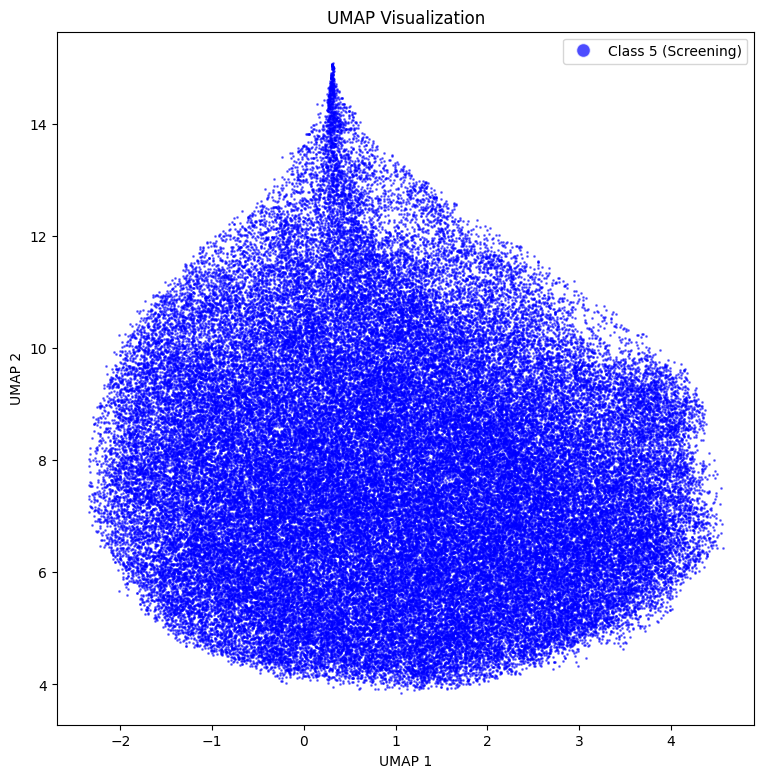

In [12]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Create an array of class labels, one for each data point
labels = ["Class 5 (Screening)"] * embeddings_flat.shape[0]

plt.figure(figsize=(9, 9))

# Scatter plot with tiny points
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], 
                      c='blue', label='Class 5 (Screening)', 
                      alpha=0.5, s=1)

# Custom legend handle with bigger dot
legend_handle = Line2D([0], [0], marker='o', color='w', label='Class 5 (Screening)',
                       markerfacecolor='blue', markersize=10, alpha=0.7)

plt.legend(handles=[legend_handle])
plt.title("UMAP Visualization")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

In [13]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Parameters
k = 10         # Number of nearest neighbors
n = 1000        # Number of outliers to select

# UMAP coordinates: assume umap_result is [100k, 2] array
x_coords = np.asarray(umap_result[:, 0])
y_coords = np.asarray(umap_result[:, 1])
coords = np.column_stack((x_coords, y_coords))

# Fit kNN model to all screening cells (since all are Class 5)
nbrs = NearestNeighbors(n_neighbors=k).fit(coords)

# Get distances to k nearest neighbors
distances, _ = nbrs.kneighbors(coords)

# Compute average distance to k nearest neighbors
avg_knn_dist = distances.mean(axis=1)

# Identify indices of the top-n farthest (most isolated) cells
outlier_indices = np.argsort(avg_knn_dist)[-n:]

# If you have a list of cell IDs, retrieve the outlier ones
outlier_cell_ids = cell_ids_list[outlier_indices]

# Optional: Get UMAP coords of the outliers
outlier_coords = coords[outlier_indices]

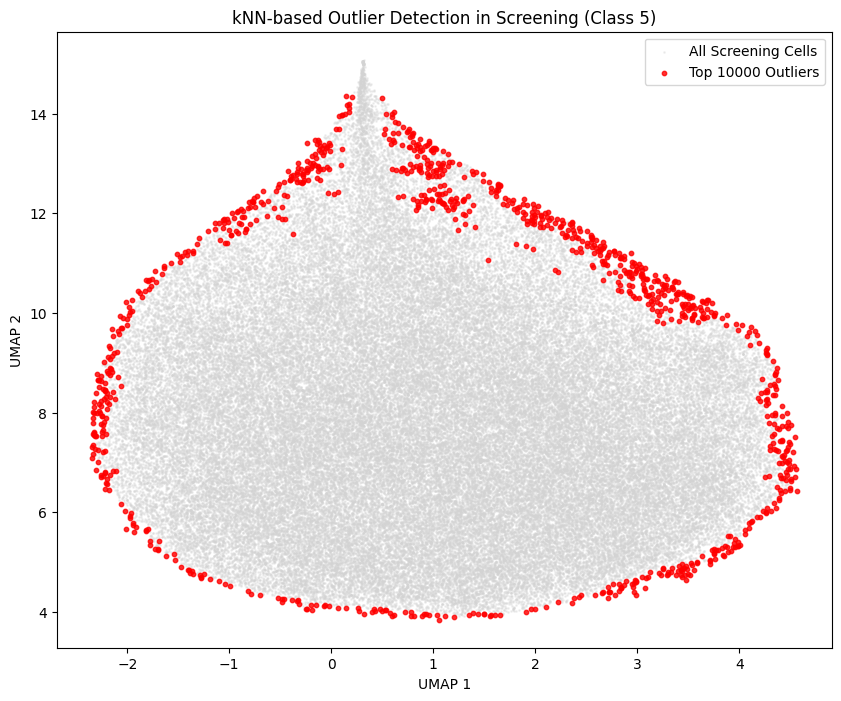

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, s=1, alpha=0.3, c='lightgrey', label='All Screening Cells')
plt.scatter(x_coords[outlier_indices], y_coords[outlier_indices], 
            s=10, alpha=0.8, c='red', label='Top 10000 Outliers')
plt.legend()
plt.title("kNN-based Outlier Detection in Screening (Class 5)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

In [15]:
# Save outlier cell IDs to a file
save_path = "./active_learning_output_files/blue_model_knn_screening_hits.txt"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
np.savetxt(save_path, outlier_cell_ids, fmt="%s")
print(f"Saved {len(outlier_cell_ids)} potential screening hits to {save_path}")

Saved 1000 potential screening hits to ./active_learning_output_files/blue_model_knn_screening_hits.txt


In [108]:
!rm -rf ~/.local/share/Trash/*

In [17]:
import numpy as np
import pandas as pd
import umap
import umap.umap_ as umap  
import matplotlib.pyplot as plt

# Define binning function based on autophagy_off score
def assign_bin(score):
    if score > 0.99999:
        return "bin 1"
    elif score > 0.999:
        return "bin 2"
    elif score > 0.9975:
        return "bin 3"
    elif score > 0.995:
        return "bin 4"
    elif score > 0.99:
        return "bin 5"
    elif score > 0.98:
        return "bin 6"
    else:
        return "CSH"

    
# Step 2: Apply binning function to create a new column
df = pd.read_csv("active_learning_autophagy21_classification_scores_LRZ_random_screening_100k.csv")
df

# Apply binning function to the dataframe
df["Bin"] = df["Autophagy Off Score"].apply(assign_bin)
df["Cell ID"] = df["Cell ID"].astype(str)
df

Cell ID  Autophagy On Score  Autophagy Off Score  Bin
0      294674            0.999973         2.701664e-05  CSH
1      247918            0.996398         3.602020e-03  CSH
2      136301            0.999999         1.488861e-06  CSH
3      467709            0.999999         6.879398e-07  CSH
4      156705            1.000000         6.414813e-08  CSH
...       ...                 ...                  ...  ...
99995    4066            0.999968         3.199371e-05  CSH
99996   49644            0.999999         7.839663e-07  CSH
99997  313183            0.994087         5.912762e-03  CSH
99998  166426            0.999996         3.755230e-06  CSH
99999  432784            1.000000         1.306178e-07  CSH

[100000 rows x 4 columns]

In [18]:
# Count the number of instances in each bin
bin_counts = df["Bin"].value_counts().sort_index()

# Display the counts
print(bin_counts)

CSH      99005
bin 1       25
bin 2      432
bin 3      180
bin 4      114
bin 5      107
bin 6      137
Name: Bin, dtype: int64


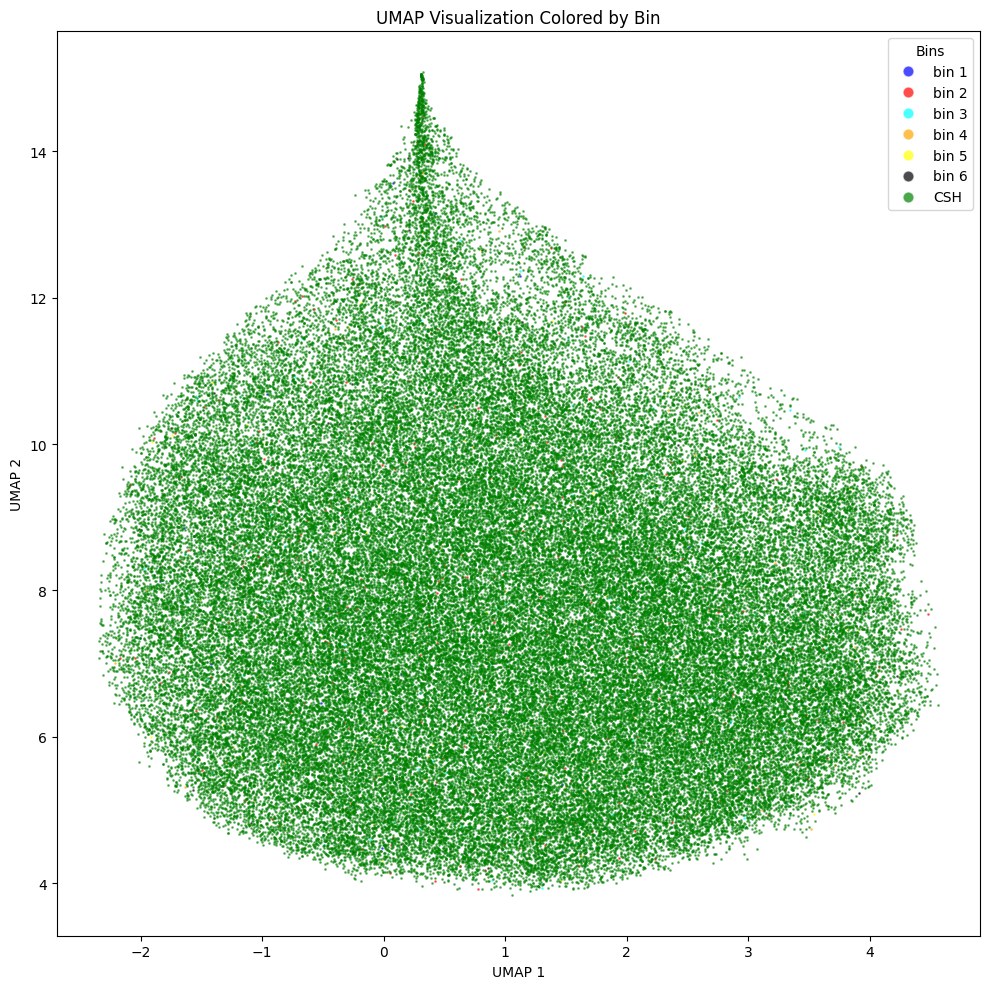

In [19]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assume df has a 'Bin' column and is aligned with umap_result
# and that umap_result.shape[0] == len(df)

# Define your bin colors
bin_colors = {
    "bin 1": "blue",
    "bin 2": "red",
    "bin 3": "cyan",
    "bin 4": "orange",
    "bin 5": "yellow",
    "bin 6": "black", 
    "CSH": "green"
}

# Get the bin labels for each point
bin_labels = df["Bin"].values

# Prepare the figure
plt.figure(figsize=(10, 10))

# Plot each bin separately for color control
for bin_label, color in bin_colors.items():
    mask = bin_labels == bin_label
    plt.scatter(umap_result[mask, 0], umap_result[mask, 1],
                color=color, s=1, alpha=0.5, label=bin_label)

# Custom legend with bigger dots
legend_handles = [
    Line2D([0], [0], marker='o', color='w', label=bin_label,
           markerfacecolor=color, markersize=8, alpha=0.7)
    for bin_label, color in bin_colors.items()
]

plt.legend(handles=legend_handles, title="Bins")
plt.title("UMAP Visualization Colored by Bin")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(False)
plt.tight_layout()
plt.show()

In [21]:
import numpy as np

# Load the file
load_path = "./active_learning_output_files/blue_model_knn_screening_hits.txt"
cell_ids_to_find = np.loadtxt(load_path, dtype=str).tolist()

# Confirm
print(f"Loaded {len(cell_ids_to_find)} cell IDs")
print(cell_ids_to_find[:10])  # preview first 10

Loaded 1000 cell IDs
['51426', '320707', '118612', '301015', '115801', '297066', '447391', '165986', '393998', '316158']


In [22]:
# Merge bin information into filtered_df
filtered_df = df[df["Cell ID"].isin(cell_ids_to_find)]
filtered_df

Cell ID  Autophagy On Score  Autophagy Off Score    Bin
283    435112            0.005339         9.946607e-01  bin 5
439    461677            0.999998         1.725722e-06    CSH
527    175818            0.999985         1.469051e-05    CSH
593    357169            0.999997         2.502657e-06    CSH
738    119284            0.992147         7.852526e-03    CSH
...       ...                 ...                  ...    ...
99587   32085            1.000000         9.469003e-08    CSH
99606  205856            0.999988         1.247208e-05    CSH
99608  363657            0.987219         1.278135e-02    CSH
99761  388643            0.015833         9.841673e-01  bin 6
99763  397093            0.999946         5.442289e-05    CSH

[1000 rows x 4 columns]

In [68]:
# Step 1: Remove duplicates so we only keep the first occurrence of each Cell ID
filtered_df = df[df["Cell ID"].isin(cell_ids_to_find)].drop_duplicates(subset="Cell ID", keep="first")

# Step 2: Ensure exactly 400 rows (remove extra if still >400)
if len(filtered_df) > 1000:
    filtered_df = filtered_df.iloc[:400]  # Keep only first 400 rows

# Step 3: Check if there are any unexpected Cell IDs in filtered_df
unexpected_ids = set(filtered_df["Cell ID"]) - set(cell_ids_to_find)

# Step 4: Print results
print(f"Final filtered_df shape: {filtered_df.shape}")  # Should be (400, X)
print(f"Unexpected Cell IDs (should be empty): {unexpected_ids}")  

Final filtered_df shape: (998, 4)
Unexpected Cell IDs (should be empty): set()


In [23]:
# Extract indices of highlighted screening cells
cell_ids_array = cell_ids_list.astype(str)  # Convert all cell IDs to string
highlighted_indices = np.isin(cell_ids_array, filtered_df["Cell ID"].values)  # Boolean mask

# Extract UMAP coordinates of these highlighted cells
highlighted_x = umap_result[highlighted_indices, 0]
highlighted_y = umap_result[highlighted_indices, 1]

# Merge UMAP results with bin information
highlighted_bins = filtered_df.set_index("Cell ID").loc[cell_ids_array[highlighted_indices], "Bin"].values

# Define colors for bins
bin_colors = {
    "bin 1": "blue",
    "bin 2": "red",
    "bin 3": "cyan",
    "bin 4": "orange",
    "bin 5": "yellow",
    "bin 6": "black", 
    "CSH": "green"
}

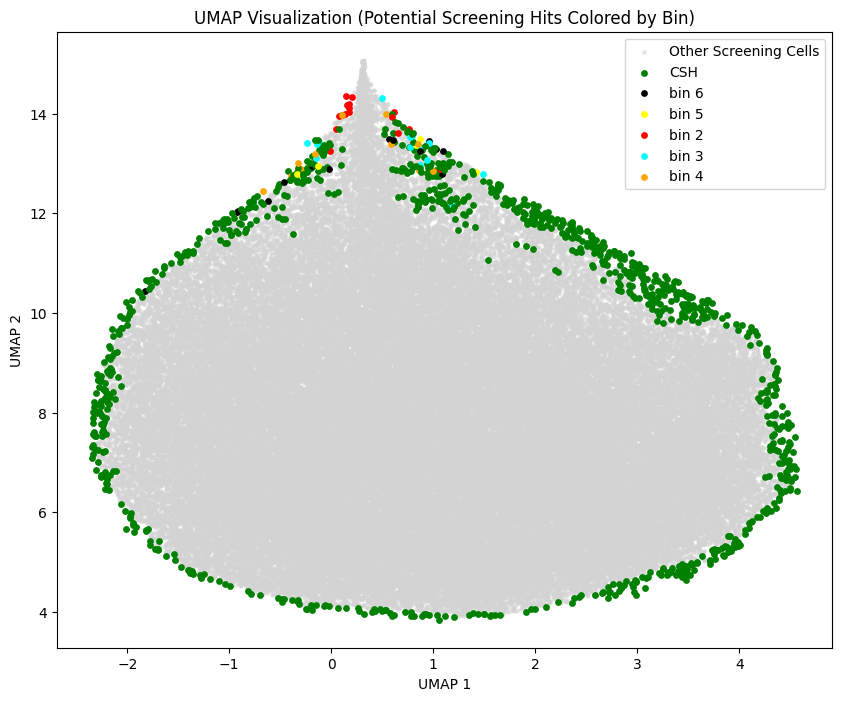

In [24]:
# Plot UMAP
plt.figure(figsize=(10, 8))

# Plot all cells in light grey
plt.scatter(umap_result[:, 0], umap_result[:, 1], color='lightgrey', s=5, alpha=0.5, label="Other Screening Cells")

# Overlay highlighted screening cells in their bin colors
for i, bin_label in enumerate(highlighted_bins):
    plt.scatter(highlighted_x[i], highlighted_y[i], color=bin_colors[bin_label], s=15, label=bin_label if bin_label not in plt.gca().get_legend_handles_labels()[1] else "")

plt.legend()
plt.title('UMAP Visualization (Potential Screening Hits Colored by Bin)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(False)
plt.show()

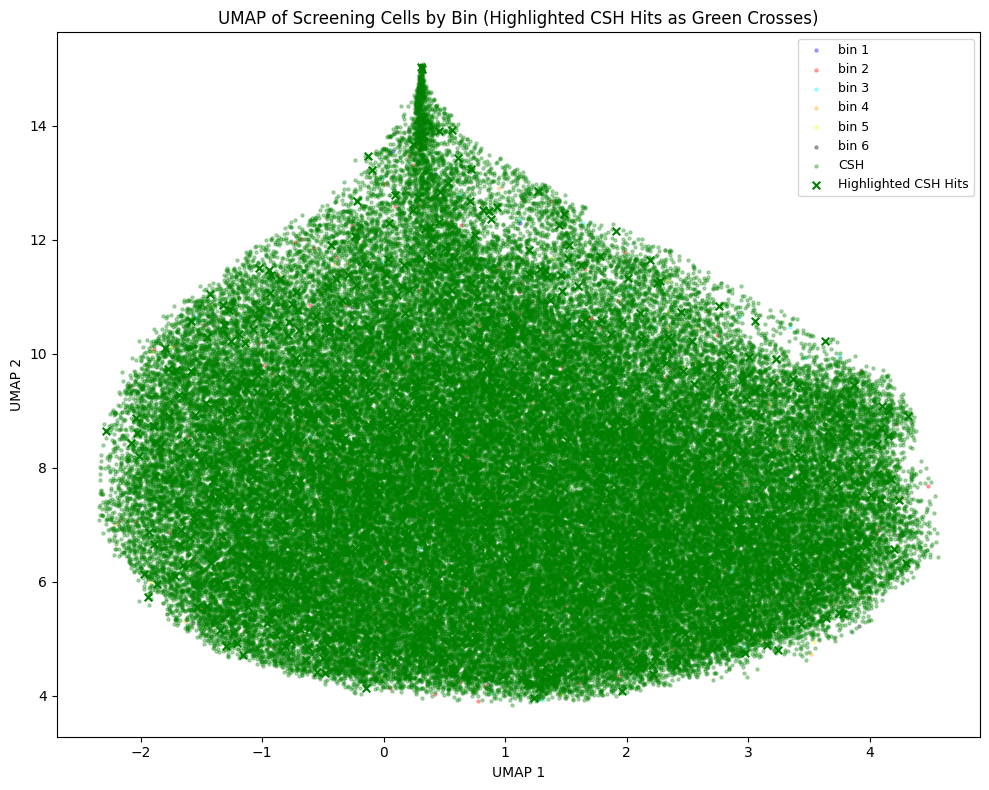

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Get bin labels and colors for all 100k cells
all_bins = df["Bin"].values
all_cell_ids = df["Cell ID"].values.astype(str)

# Create a NumPy array of UMAP coordinates for all cells
umap_coords = np.array(umap_result)

# Plot: Set up figure
plt.figure(figsize=(10, 8))

# 1. Plot all 100k screening cells by bin color
for bin_label, color in bin_colors.items():
    mask = (all_bins == bin_label)
    plt.scatter(
        umap_coords[mask, 0],
        umap_coords[mask, 1],
        color=color,
        s=5,
        alpha=0.3,
        label=bin_label
    )

# 2. Highlight only CSH cells from filtered_df as green crosses
filtered_csh = filtered_df[filtered_df["Bin"] == "CSH"]
highlight_csh_ids = filtered_csh["Cell ID"].values

# Boolean mask over entire UMAP data to find matching CSH cells
highlight_csh_mask = np.isin(all_cell_ids, highlight_csh_ids)
highlight_csh_coords = umap_coords[highlight_csh_mask]

# Plot the crosses
plt.scatter(
    highlight_csh_coords[:, 0],
    highlight_csh_coords[:, 1],
    color='green',
    s=30,
    marker='x',
    label='Highlighted CSH Hits'
)

# Final touches
plt.legend(loc='best', fontsize=9)
plt.title("UMAP of Screening Cells by Bin (Highlighted CSH Hits as Green Crosses)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(False)
plt.tight_layout()
plt.show()

Total number of final_df entries: 1000

Cell Counts per Bin:
CSH      940
bin 3     15
bin 2     15
bin 6     14
bin 4     11
bin 5      5
Name: Bin, dtype: int64

Cell Percentages per Bin:
CSH      94.0
bin 3     1.5
bin 2     1.5
bin 6     1.4
bin 4     1.1
bin 5     0.5
Name: Bin, dtype: float64


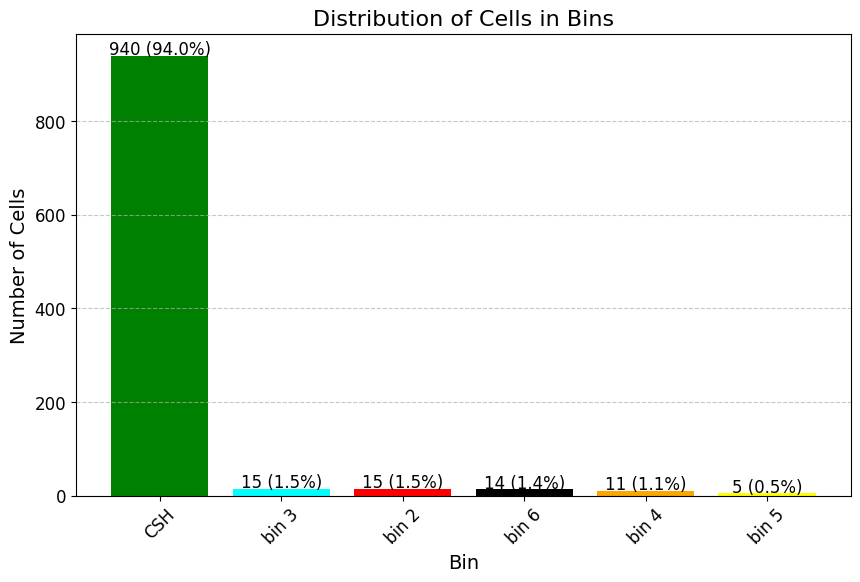

In [26]:
# Step 1: Define the same bin color mapping from UMAP
bin_colors = {
    "bin 1": "blue",
    "bin 2": "red",
    "bin 3": "cyan",
    "bin 4": "orange",
    "bin 5": "yellow",
    "bin 6": "black",
    "CSH": "green"
}

# Step 2: Count occurrences of each bin
bin_counts = filtered_df["Bin"].value_counts()

# Step 3: Compute percentages
total_cells = len(filtered_df)
bin_percentages = (bin_counts / total_cells) * 100

# Step 4: Print results
print(f"Total number of final_df entries: {total_cells}\n")
print("Cell Counts per Bin:")
print(bin_counts)
print("\nCell Percentages per Bin:")
print(bin_percentages)

# Step 5: Plot bar chart with UMAP colors
plt.figure(figsize=(10, 6))
bars = plt.bar(bin_counts.index, bin_counts.values, 
               color=[bin_colors[bin] for bin in bin_counts.index])

# Step 6: Add labels on top of bars (count + percentage)
for bar, count, percentage in zip(bars, bin_counts.values, bin_percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f"{count} ({percentage:.1f}%)", 
             ha="center", fontsize=12)

# Formatting
plt.xlabel("Bin", fontsize=14)
plt.ylabel("Number of Cells", fontsize=14)
plt.title("Distribution of Cells in Bins", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Step 7: Save the plot
output_path = "./active_learning_output_files/bin_distribution.png"
#plt.savefig(output_path, dpi=300, bbox_inches="tight")

# Show plot
plt.show()

In [109]:
import matplotlib.pyplot as plt
import os

def visualize_csh_images_from_filtered_df(filtered_df, data_loader, save_path="./active_learning_output_files/csh_images_filtered.png"):
    """
    Visualizes 5 CSH cell images from `filtered_df` and saves the figure.
    
    Args:
        filtered_df (pd.DataFrame): DataFrame containing the filtered cells (with 'Bin' and 'Cell ID').
        data_loader (DataLoader): PyTorch DataLoader containing images, labels, and cell IDs.
        save_path (str): Path to save the output image.
    """
    # Filter "CSH" cells from the filtered_df
    csh_cell_ids = filtered_df[filtered_df["Bin"] == "CSH"]["Cell ID"].unique()[:5]
    
    if csh_cell_ids.size == 0:  # Check if the array is empty
        print("No CSH cell images to visualize in the filtered data.")
        return

    # Convert cell IDs to strings for comparison
    csh_cell_ids = set(str(cid) for cid in csh_cell_ids)
    images_to_plot = []

    # Collect matching images from the DataLoader
    for images, labels, cell_ids in data_loader:
        for i in range(len(cell_ids)):
            cid = str(cell_ids[i].item())
            if cid in csh_cell_ids:
                image_data = images[i].cpu().numpy()
                images_to_plot.append((cid, image_data))

                # Stop once we have 5 images
                if len(images_to_plot) >= 5:
                    break
        if len(images_to_plot) >= 5:
            break

    # Plot
    num_images = len(images_to_plot)
    cols = min(5, num_images)
    rows = int(np.ceil(num_images / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axes = np.array(axes).reshape(-1)  # Flatten for consistency

    for ax, (cid, img_data) in zip(axes, images_to_plot):
        num_channels = img_data.shape[0]
        if num_channels == 1:
            ax.imshow(img_data[0], cmap="viridis")
        else:
            ax.imshow(np.moveaxis(img_data, 0, -1))  # (C, H, W) -> (H, W, C)

        ax.set_title(f"Cell ID: {cid}", fontsize=10)
        ax.axis("off")

    # Hide unused axes
    for ax in axes[len(images_to_plot):]:
        ax.axis("off")

    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    print(f"Saved CSH cell images from filtered_df to {save_path}")
    plt.show()

Saved CSH cell images from filtered_df to ./active_learning_output_files/csh_images_filtered.png


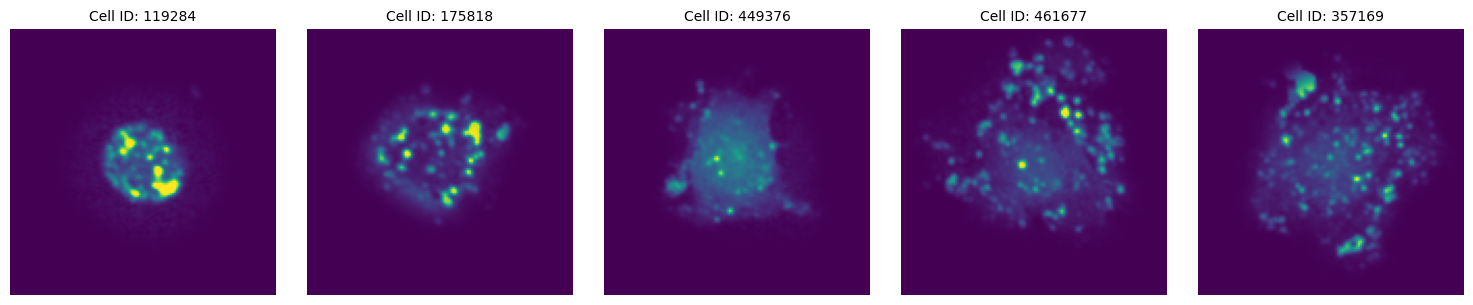

In [28]:
# Assuming filtered_df is already created from the previous steps
visualize_csh_images_from_filtered_df(filtered_df, test_data_loader)

In [29]:
# Get list of bins excluding "other"
valid_bins = ["bin 1", "bin 2", "bin 3", "bin 4", "bin 5", "bin 6"]

# Filter for rows where "Bin" is in valid_bins
filtered_bin_cells = filtered_df[filtered_df["Bin"].isin(valid_bins)]

# Extract the Cell IDs as a list
filtered_bin_cell_ids = filtered_bin_cells["Cell ID"].tolist()

# Print first few to check
print(filtered_bin_cell_ids[:10]) 
print(f"Total cells in bins 1-6, thus excised cells: {len(filtered_bin_cell_ids)}")

['435112', '500526', '443637', '230596', '52349', '504299', '442000', '266231', '264907', '187526']
Total cells in bins 1-6, thus excised cells: 60


In [31]:
# Subset filtered_df to create excised_df containing only cells in valid bins
excised_df = filtered_df[filtered_df["Cell ID"].isin(filtered_bin_cell_ids)]
#excised_df.head()

Cell ID  Autophagy On Score  Autophagy Off Score    Bin
283   435112            0.005339             0.994661  bin 5
968   500526            0.001506             0.998494  bin 3
1054  443637            0.003246             0.996754  bin 4
1858  230596            0.019974             0.980026  bin 6
2363   52349            0.000894             0.999106  bin 2

In [32]:
# Save excised_df to CSV
output_path = './active_learning_output_files/Blue_model_excised_cells.csv'
excised_df.to_csv(output_path, index=False)

# Print confirmation
print(f"Excised dataframe saved to {output_path}")

Excised dataframe saved to ./active_learning_output_files/Blue_model_excised_cells.csv


In [35]:
# Read the excised_df from the CSV file
input_path = './active_learning_output_files/Blue_model_excised_cells.csv'
excised_df_read = pd.read_csv(input_path)

# Print the first few rows to confirm
excised_df_read.head()

Cell ID  Autophagy On Score  Autophagy Off Score    Bin
0   435112            0.005339             0.994661  bin 5
1   500526            0.001506             0.998494  bin 3
2   443637            0.003246             0.996754  bin 4
3   230596            0.019974             0.980026  bin 6
4    52349            0.000894             0.999106  bin 2

### Orange model first loop


output_dim=100

In [47]:
# Read the CSV file and prevent the extra index column
ground_truth_df = pd.read_csv("/dss/dsshome1/0F/di93quv/Niklas_inputs/simulated_active_learning/final_df_reduced.csv", index_col=0)

# Print the first few rows to verify
#ground_truth_df

In [48]:
# Replace the row names (index) to include spaces, e.g., 'bin 1', 'bin 2', etc.
ground_truth_df.index = [f"bin {i+1}" for i in range(len(ground_truth_df))]

# Print the first few rows to verify
ground_truth_df

# ground_truth_df.to_csv("updated_final_df_reduced.csv")

AGAGCGCGCTCAGAAGCGAA  CATCTAGGAGCATCTACCCA  AGTGGAACTTGCCTGTGCTG  \
bin 1              0.000749              0.041151              0.020777   
bin 2              1.000000              0.007713              0.007925   
bin 3              0.000000              0.001373              0.003010   
bin 4              0.000000              0.000650              0.001072   
bin 5              0.000000              0.002454              0.001062   
bin 6              0.000000              0.000450              0.000134   

       CAGTATCCAAACGGGCTCTG  CTTGCCCTAAAGTAAAGTAC  CTTGGCGGTCCACATTGCAA  \
bin 1              0.020959              0.017536              0.016980   
bin 2              0.004914              0.002464              0.004502   
bin 3              0.001908              0.000000              0.001939   
bin 4              0.000555              0.000000              0.002656   
bin 5              0.001802              0.000535              0.000501   
bin 6              0.000997              0.000885              0.000960   

       GAATAACCAAATGCAGCGGA  TTGTTAGGGAGGCTAATCCA  CTTCACATGTATGCTCATCG  \
bin 1              0.014172              0.010241              0.009149   
bin 2              0.002635              0.001897              0.002006   
bin 3              0.000579              0.000580              0.001342   
bin 4              0.000897              0.000000              0.000000   
bin 5              0.000976              0.000000              0.000558   
bin 6              0.000262              0.000910              0.001125   

       CTTGAAAGACTCGAGTGTGT  ...  AGCACGTAATGTCCGTGGAT  GGGGAAGTAACGGATCACGT  \
bin 1              0.009043  ...              0.000523              0.000000   
bin 2              0.002738  ...              0.002470              0.000000   
bin 3              0.001373  ...              0.000000              0.002354   
bin 4              0.001121  ...              0.000272              0.000000   
bin 5              0.000000  ...              0.000000              0.000000   
bin 6              0.000216  ...              0.000000              0.000000   

       CAGGGACAAGCACTTACGCA  GAGCTGAAGCAGTGGTACAA  GCTGCGAGAAGAAACCAACG  \
bin 1          0.000000e+00              0.000000              0.000297   
bin 2          0.000000e+00              0.000000              0.000000   
bin 3          2.346073e-03              0.002418              0.000000   
bin 4          4.362724e-07              0.000000              0.000000   
bin 5          0.000000e+00              0.000417              0.002362   
bin 6          0.000000e+00              0.000185              0.000000   

       AAGACCCTGTTAGCCATCGG  CACCGTACAGATCAACGTGA  GCGGTGATTGTACACATCGA  \
bin 1          1.164600e-04          0.000000e+00          0.000000e+00   
bin 2          2.331100e-03          0.000000e+00          0.000000e+00   
bin 3          0.000000e+00          0.000000e+00          2.288554e-03   
bin 4          0.000000e+00          0.000000e+00          4.362724e-07   
bin 5          0.000000e+00          2.297496e-03          0.000000e+00   
bin 6          5.217257e-07          9.330594e-07          0.000000e+00   

       AGGCTGCAGAACATAAGACA  AGTGACATGTACAGCCACAT  
bin 1              0.000000              0.000000  
bin 2              0.000000              0.000000  
bin 3              0.000000              0.000000  
bin 4              0.002283              0.000000  
bin 5              0.000000              0.002323  
bin 6              0.000000              0.000471  

[6 rows x 100 columns]

In [50]:
import numpy as np
import torch

# Initialize lists to store the correct embeddings and labels
correct_embeddings = []
correct_labels = []

# Convert cell_ids_list to a NumPy array for efficient searching
cell_ids_array = np.array(cell_ids_list)

# Iterate through each excised cell and find its corresponding label
for idx, row in excised_df_read.iterrows():
    cell_id = row['Cell ID']  # 'Cell ID' is a column in your excised_df_read
    bin_id = row['Bin']       # 'Bin' column, which contains bin names like 'bin 1', 'bin 2', ...
    
    # Lookup the corresponding 100D vector for this bin from the ground_truth_df
    bin_name = bin_id.strip()  # Ensure no leading/trailing spaces
    
    # Extract the 100D vector corresponding to this bin from the ground_truth_df
    label = ground_truth_df.loc[bin_name].values  # Fetch 100D vector for the bin
    
    # Get the index of the cell_id from the cell_ids_list
    # Use np.where to get the index of the cell_id in the cell_ids_array
    cell_idx = np.where(cell_ids_array == cell_id)[0]

    # If the cell is found (it should always be found)
    if len(cell_idx) > 0:
        # Fetch the corresponding embedding using the index
        embedding = embeddings[cell_idx[0]]  # Use the first (and only) index from cell_idx
        correct_embeddings.append(embedding)
        correct_labels.append(label)

# Convert the embeddings and labels to numpy arrays
correct_embeddings = np.array(correct_embeddings)
correct_labels = np.array(correct_labels)

In [55]:
correct_embeddings.shape

(60, 2048)

In [54]:
correct_labels.shape

(60, 100)

In [56]:
# Convert to tensors for training
excised_embeddings_tensor = torch.tensor(correct_embeddings, dtype=torch.float32).to(device)
excised_labels_tensor = torch.tensor(correct_labels, dtype=torch.float32).to(device)

# Prepare the DataLoader for the Orange model
orange_dataset = torch.utils.data.TensorDataset(excised_embeddings_tensor, excised_labels_tensor)
orange_data_loader = torch.utils.data.DataLoader(orange_dataset, batch_size=64, shuffle=True)

In [59]:
# Get one batch from the dataloader
for inputs, labels in orange_data_loader:
    print("Inputs shape:", inputs.shape)
    print("Labels shape:", labels.shape)
    
    # Print first few values to check content
    print("First 1 inputs:", inputs[:1])  
    print("First 1 labels:", labels[:1])  
    
    break  # Only print one batch

Inputs shape: torch.Size([60, 2048])
Labels shape: torch.Size([60, 100])
First 1 inputs: tensor([[ 0.2110, -0.0005, -0.0010,  ...,  0.3169,  0.0849,  0.2687]],
       device='cuda:0')
First 1 labels: tensor([[0.0000e+00, 6.4980e-04, 1.0718e-03, 5.5475e-04, 0.0000e+00, 2.6563e-03,
         8.9742e-04, 0.0000e+00, 0.0000e+00, 1.1205e-03, 1.5601e-03, 0.0000e+00,
         0.0000e+00, 2.1814e-05, 0.0000e+00, 2.8220e-04, 3.5103e-04, 7.8539e-04,
         4.3627e-07, 1.1903e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         4.6626e-04, 4.6939e-04, 1.3680e-03, 1.3498e-03, 4.3696e-03, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 3.9810e-03, 0.0000e+00, 0.0000e+00, 3.9614e-03,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 3.5347e-03, 0.0000e+00, 7.1592e-04,
         0.0000e+00, 0.0000e+00, 4.8892e-04, 0.0000e+00, 4.3627e-07, 0.0000e+00,
         0.0000e+00, 2.7398e-04, 0.0000e+00, 4.3627e-07, 2.9959e-03, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.

In [60]:
def convert_to_rgb(inputs):
    # Convert to (batch_size, 3, height, width) by repeating the channel 3 times
    return inputs.repeat(1, 3, 1, 1)  

In [68]:
from tqdm import tqdm 
import torch
import torch.nn as nn

# Initialize the Orange Model (with regression head)
orange_model = ConvNextWithRegressionHead(config, output_dim=100)
orange_model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # for regression
optimizer = torch.optim.Adam(orange_model.parameters(), lr=1e-4)

# Function to convert grayscale to RGB
def convert_to_rgb(grayscale_tensor):
    # Convert grayscale (1 channel) to RGB (3 channels)
    return grayscale_tensor.repeat(1, 3, 1, 1)

# Training the Orange Model
orange_model.train()
num_epochs = 5

for epoch in range(num_epochs):
    print(f'Epoch: {epoch + 1}/{num_epochs}')
    
    # Use tqdm for the data loader to add a progress bar
    running_loss = 0.0
    with tqdm(total=len(orange_data_loader), desc=f'Epoch {epoch+1}', ncols=100) as pbar:
        for inputs, labels in orange_data_loader:
            # Check shape of labels for debugging
            # print(f'Labels shape: {labels.shape}')
            
            optimizer.zero_grad()

            # Convert inputs from grayscale (1 channel) to RGB 
            inputs = convert_to_rgb(inputs).to(device)    

            # Forward pass
            outputs = orange_model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backpropagate and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update the progress bar with the loss of the current batch
            pbar.set_postfix({'Loss': running_loss / (pbar.n + 1)})
            pbar.update(1) 

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(orange_data_loader)}")

Epoch: 1/5


Epoch 1: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  9.29it/s, Loss=0.283]


Epoch 1/5, Loss: 0.28311073780059814
Epoch: 2/5


Epoch 2: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  9.74it/s, Loss=0.359]


Epoch 2/5, Loss: 0.35904234647750854
Epoch: 3/5


Epoch 3: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 11.18it/s, Loss=0.274]


Epoch 3/5, Loss: 0.2743785083293915
Epoch: 4/5


Epoch 4: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 11.14it/s, Loss=0.222]


Epoch 4/5, Loss: 0.22166931629180908
Epoch: 5/5


Epoch 5: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 11.16it/s, Loss=0.182]

Epoch 5/5, Loss: 0.18153372406959534


In [69]:
# Save the model after training
model_save_path = './active_learning_output_files/orange_model_1.pth'
torch.save(orange_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./active_learning_output_files/orange_model_1.pth


In [73]:
class ConvNextWithRegressionHead(ConvNextModel):
    def __init__(self, config, output_dim=1): 
        super().__init__(config)
        self.regression_head = nn.Linear(config.hidden_sizes[-1], output_dim)

    def forward(self, pixel_values, **kwargs):
        outputs = super().forward(pixel_values, **kwargs)

        # Extract the pooled output
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
            embeddings = outputs.pooler_output
        else:
            embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
        
        # Pass embeddings through regression head
        regression_output = self.regression_head(embeddings)
        return regression_output

In [74]:
model = ConvNextWithRegressionHead.from_pretrained(
    "facebook/convnext-xlarge-224-22k", config=config, output_dim=100  
)
model.to(device)

Some weights of ConvNextWithRegressionHead were not initialized from the model checkpoint at facebook/convnext-xlarge-224-22k and are newly initialized: ['convnext.regression_head.bias', 'convnext.regression_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ConvNextWithRegressionHead(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)

In [75]:
# Load the saved model
model.load_state_dict(torch.load(model_save_path))
model.to(device)

ConvNextWithRegressionHead(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)

In [76]:
def load_dataset(save_path, batch_size):
    """
    Load dataset with images, labels, and cell IDs.

    Parameters:
    - save_path: Path where the dataset is stored
    - batch_size: Batch size for DataLoader

    Returns:
    - DataLoader for the dataset
    """
    images_tensor, labels_tensor, cell_ids_tensor = torch.load(save_path)

    # Create a TensorDataset from the loaded tensors
    dataset = torch.utils.data.TensorDataset(images_tensor, labels_tensor, cell_ids_tensor)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print(f"Loaded dataset from {save_path}")
    return data_loader

# Load the balanced test dataset
test_data_loader = load_dataset(
    "/dss/dsshome1/0F/di93quv/LRZ_Random_Screening_subset_100k.pt",
    batch_size=64
)



Loaded dataset from /dss/dsshome1/0F/di93quv/LRZ_Random_Screening_subset_100k.pt


In [81]:
embeddings = []
labels_list = []
cell_ids_list = []  

model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        inputs, labels, cell_ids = batch  
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Convert inputs from single-channel to 3 channels
        inputs = convert_to_rgb(inputs)

        # Forward pass to get logits and pooler output
        pooler_output = model(inputs)

        # Append pooler_output, labels, and cell_ids
        embeddings.append(pooler_output.cpu().detach().numpy())
        labels_list.append(labels.cpu().detach().numpy())
        cell_ids_list.append(cell_ids.cpu().detach().numpy())  
        
# Convert to numpy arrays
embeddings = np.concatenate(embeddings, axis=0)
labels_list = np.concatenate(labels_list, axis=0)
cell_ids_list = np.concatenate(cell_ids_list, axis=0) 

In [82]:
# Flatten the embeddings to shape [samples, features]
embeddings_flat = embeddings.reshape(embeddings.shape[0], -1)

#UMAP
umap_reducer = umap.UMAP(n_components=2)
umap_result = umap_reducer.fit_transform(embeddings_flat)

# Define new class labels 
class_labels = ["Class 5 (Screening)"]

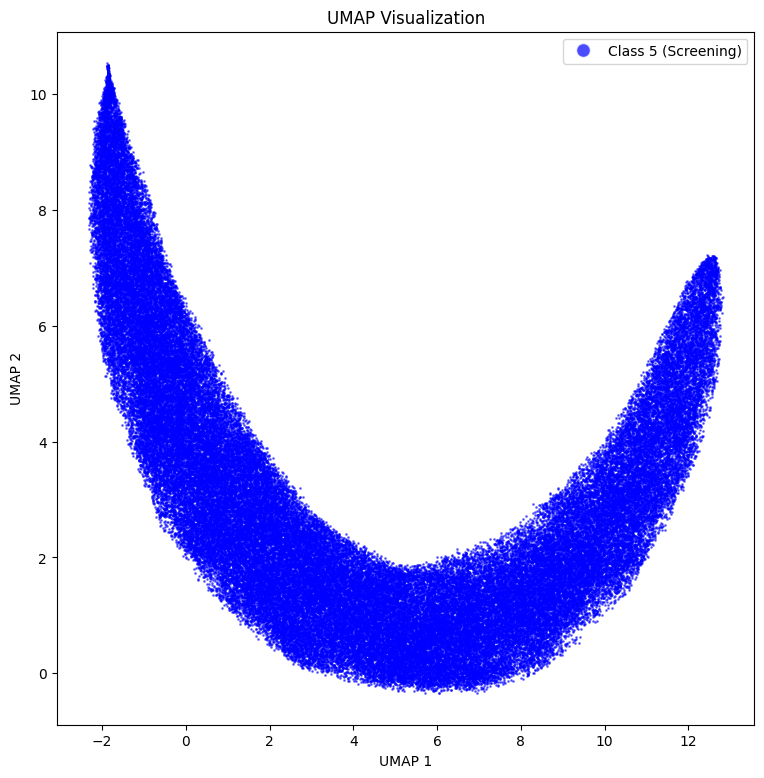

In [83]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Create an array of class labels, one for each data point
labels = ["Class 5 (Screening)"] * embeddings_flat.shape[0]

plt.figure(figsize=(9, 9))

# Scatter plot with tiny points
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], 
                      c='blue', label='Class 5 (Screening)', 
                      alpha=0.5, s=1)

# Custom legend handle with bigger dot
legend_handle = Line2D([0], [0], marker='o', color='w', label='Class 5 (Screening)',
                       markerfacecolor='blue', markersize=10, alpha=0.7)

plt.legend(handles=[legend_handle])
plt.title("UMAP Visualization")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

In [84]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Parameters
k = 10         # Number of nearest neighbors
n = 1000        # Number of outliers to select

# UMAP coordinates: assume umap_result is [100k, 2] array
x_coords = np.asarray(umap_result[:, 0])
y_coords = np.asarray(umap_result[:, 1])
coords = np.column_stack((x_coords, y_coords))

# Fit kNN model to all screening cells (since all are Class 5)
nbrs = NearestNeighbors(n_neighbors=k).fit(coords)

# Get distances to k nearest neighbors
distances, _ = nbrs.kneighbors(coords)

# Compute average distance to k nearest neighbors
avg_knn_dist = distances.mean(axis=1)

# Identify indices of the top-n farthest (most isolated) cells
outlier_indices = np.argsort(avg_knn_dist)[-n:]

# If you have a list of cell IDs, retrieve the outlier ones
outlier_cell_ids = cell_ids_list[outlier_indices]

# Optional: Get UMAP coords of the outliers
outlier_coords = coords[outlier_indices]

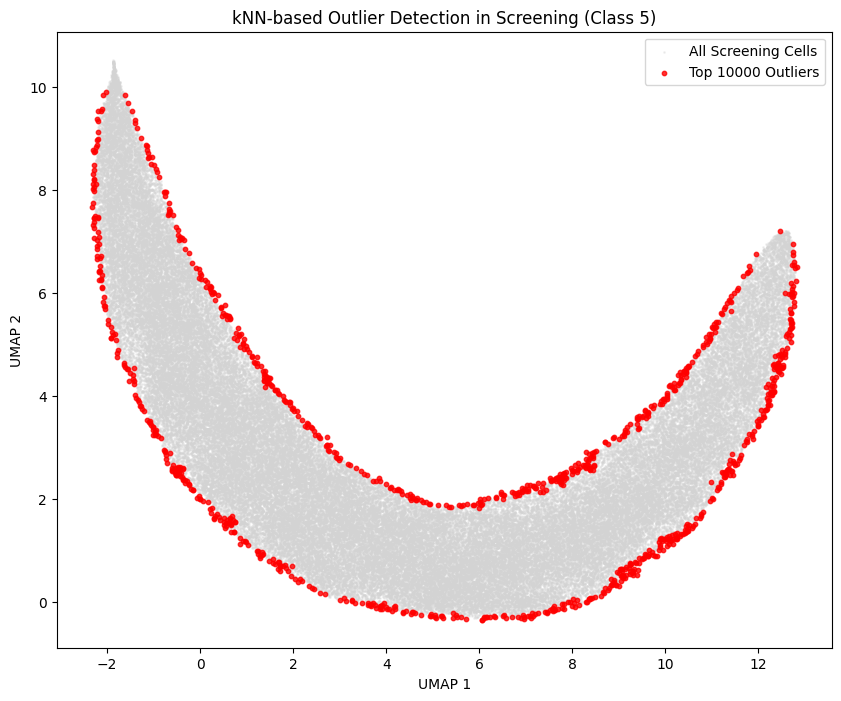

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, s=1, alpha=0.3, c='lightgrey', label='All Screening Cells')
plt.scatter(x_coords[outlier_indices], y_coords[outlier_indices], 
            s=10, alpha=0.8, c='red', label='Top 10000 Outliers')
plt.legend()
plt.title("kNN-based Outlier Detection in Screening (Class 5)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

In [86]:
# Save outlier cell IDs to a file
save_path = "./active_learning_output_files/orange_model_1_knn_screening_hits.txt"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
np.savetxt(save_path, outlier_cell_ids, fmt="%s")
print(f"Saved {len(outlier_cell_ids)} potential screening hits to {save_path}")

Saved 1000 potential screening hits to ./active_learning_output_files/orange_model_1_knn_screening_hits.txt


In [87]:
import numpy as np
import pandas as pd
import umap
import umap.umap_ as umap  
import matplotlib.pyplot as plt

# Define binning function based on autophagy_off score
def assign_bin(score):
    if score > 0.99999:
        return "bin 1"
    elif score > 0.999:
        return "bin 2"
    elif score > 0.9975:
        return "bin 3"
    elif score > 0.995:
        return "bin 4"
    elif score > 0.99:
        return "bin 5"
    elif score > 0.98:
        return "bin 6"
    else:
        return "CSH"

    
# Step 2: Apply binning function to create a new column
df = pd.read_csv("active_learning_autophagy21_classification_scores_LRZ_random_screening_100k.csv")
df

# Apply binning function to the dataframe
df["Bin"] = df["Autophagy Off Score"].apply(assign_bin)
df["Cell ID"] = df["Cell ID"].astype(str)
df

Cell ID  Autophagy On Score  Autophagy Off Score  Bin
0      294674            0.999973         2.701664e-05  CSH
1      247918            0.996398         3.602020e-03  CSH
2      136301            0.999999         1.488861e-06  CSH
3      467709            0.999999         6.879398e-07  CSH
4      156705            1.000000         6.414813e-08  CSH
...       ...                 ...                  ...  ...
99995    4066            0.999968         3.199371e-05  CSH
99996   49644            0.999999         7.839663e-07  CSH
99997  313183            0.994087         5.912762e-03  CSH
99998  166426            0.999996         3.755230e-06  CSH
99999  432784            1.000000         1.306178e-07  CSH

[100000 rows x 4 columns]

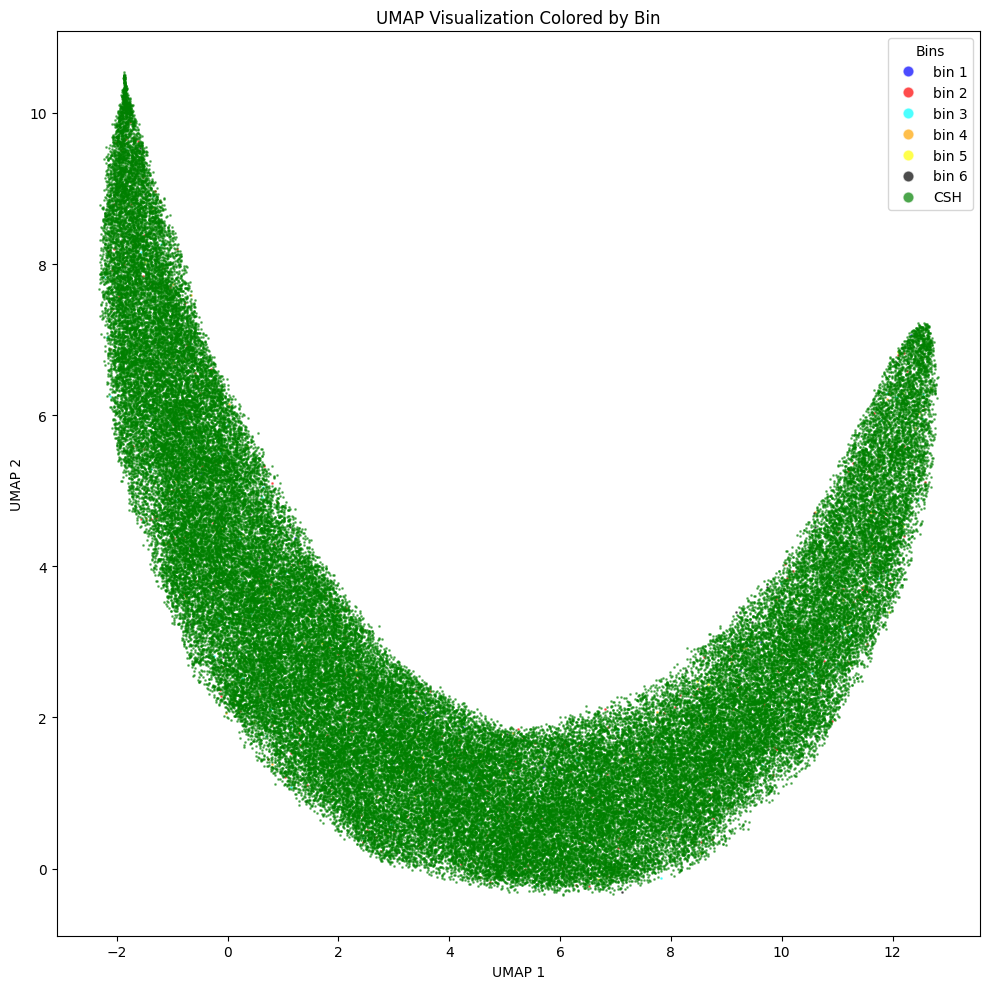

In [88]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assume df has a 'Bin' column and is aligned with umap_result
# and that umap_result.shape[0] == len(df)

# Define your bin colors
bin_colors = {
    "bin 1": "blue",
    "bin 2": "red",
    "bin 3": "cyan",
    "bin 4": "orange",
    "bin 5": "yellow",
    "bin 6": "black", 
    "CSH": "green"
}

# Get the bin labels for each point
bin_labels = df["Bin"].values

# Prepare the figure
plt.figure(figsize=(10, 10))

# Plot each bin separately for color control
for bin_label, color in bin_colors.items():
    mask = bin_labels == bin_label
    plt.scatter(umap_result[mask, 0], umap_result[mask, 1],
                color=color, s=1, alpha=0.5, label=bin_label)

# Custom legend with bigger dots
legend_handles = [
    Line2D([0], [0], marker='o', color='w', label=bin_label,
           markerfacecolor=color, markersize=8, alpha=0.7)
    for bin_label, color in bin_colors.items()
]

plt.legend(handles=legend_handles, title="Bins")
plt.title("UMAP Visualization Colored by Bin")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(False)
plt.tight_layout()
plt.show()

In [89]:
import numpy as np

# Load the file
load_path = "./active_learning_output_files/orange_model_1_knn_screening_hits.txt"
cell_ids_to_find = np.loadtxt(load_path, dtype=str).tolist()

# Confirm
print(f"Loaded {len(cell_ids_to_find)} cell IDs")
print(cell_ids_to_find[:10])  # preview first 10

# Merge bin information into filtered_df
filtered_df = df[df["Cell ID"].isin(cell_ids_to_find)]
filtered_df

Loaded 1000 cell IDs
['429765', '252054', '262239', '172404', '122173', '58529', '93533', '472585', '186781', '382787']


Cell ID  Autophagy On Score  Autophagy Off Score  Bin
25     499420            0.999951             0.000048  CSH
29     387006            0.999991             0.000009  CSH
147    315621            0.999995             0.000005  CSH
212     61398            0.999995             0.000005  CSH
384     73596            0.999988             0.000012  CSH
...       ...                 ...                  ...  ...
99602  195236            0.999906             0.000094  CSH
99815  204676            0.999990             0.000010  CSH
99856  304977            0.999909             0.000091  CSH
99862   21874            0.999996             0.000004  CSH
99896  436328            0.999967             0.000033  CSH

[1000 rows x 4 columns]

In [90]:
# Step 1: Remove duplicates so we only keep the first occurrence of each Cell ID
filtered_df = df[df["Cell ID"].isin(cell_ids_to_find)].drop_duplicates(subset="Cell ID", keep="first")

# Step 2: Ensure exactly 400 rows (remove extra if still >400)
if len(filtered_df) > 1000:
    filtered_df = filtered_df.iloc[:400]  # Keep only first 400 rows

# Step 3: Check if there are any unexpected Cell IDs in filtered_df
unexpected_ids = set(filtered_df["Cell ID"]) - set(cell_ids_to_find)

# Step 4: Print results
print(f"Final filtered_df shape: {filtered_df.shape}")  # Should be (400, X)
print(f"Unexpected Cell IDs (should be empty): {unexpected_ids}")

Final filtered_df shape: (1000, 4)
Unexpected Cell IDs (should be empty): set()


In [91]:
# Extract indices of highlighted screening cells
cell_ids_array = cell_ids_list.astype(str)  # Convert all cell IDs to string
highlighted_indices = np.isin(cell_ids_array, filtered_df["Cell ID"].values)  # Boolean mask

# Extract UMAP coordinates of these highlighted cells
highlighted_x = umap_result[highlighted_indices, 0]
highlighted_y = umap_result[highlighted_indices, 1]

# Merge UMAP results with bin information
highlighted_bins = filtered_df.set_index("Cell ID").loc[cell_ids_array[highlighted_indices], "Bin"].values

# Define colors for bins
bin_colors = {
    "bin 1": "blue",
    "bin 2": "red",
    "bin 3": "cyan",
    "bin 4": "orange",
    "bin 5": "yellow",
    "bin 6": "black", 
    "CSH": "green"
}

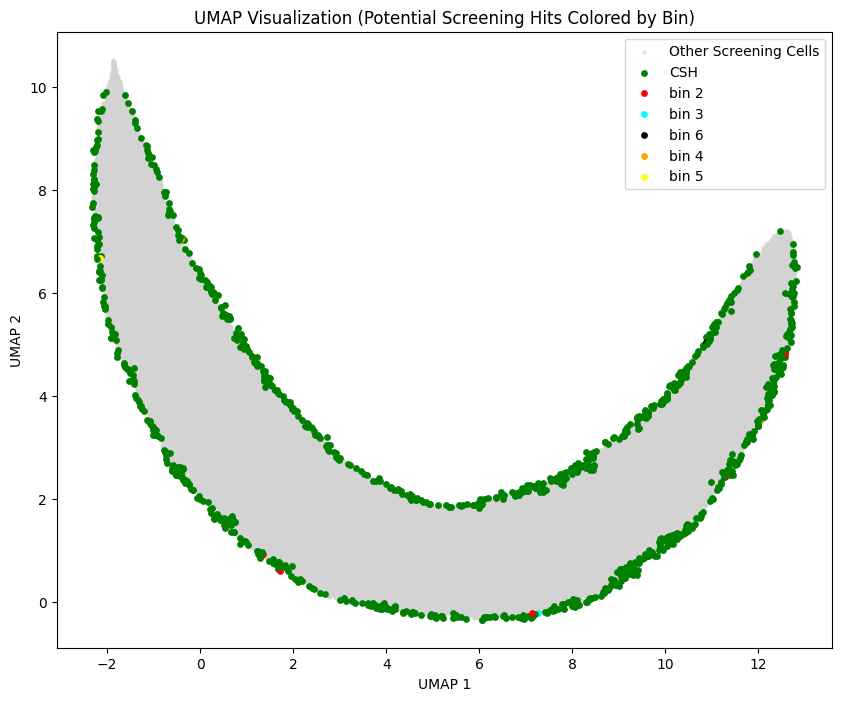

In [92]:
# Plot UMAP
plt.figure(figsize=(10, 8))

# Plot all cells in light grey
plt.scatter(umap_result[:, 0], umap_result[:, 1], color='lightgrey', s=5, alpha=0.5, label="Other Screening Cells")

# Overlay highlighted screening cells in their bin colors
for i, bin_label in enumerate(highlighted_bins):
    plt.scatter(highlighted_x[i], highlighted_y[i], color=bin_colors[bin_label], s=15, label=bin_label if bin_label not in plt.gca().get_legend_handles_labels()[1] else "")

plt.legend()
plt.title('UMAP Visualization (Potential Screening Hits Colored by Bin)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(False)
plt.show()


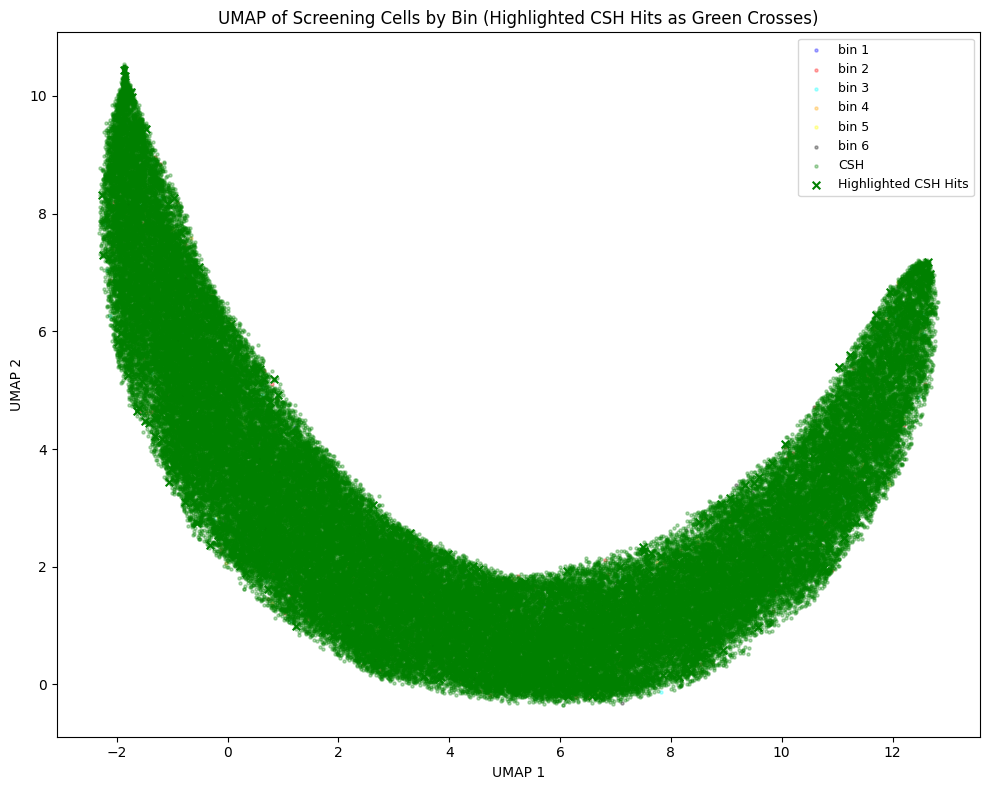

In [93]:
# Get bin labels and colors for all 100k cells
all_bins = df["Bin"].values
all_cell_ids = df["Cell ID"].values.astype(str)

# Create a NumPy array of UMAP coordinates for all cells
umap_coords = np.array(umap_result)

# Plot: Set up figure
plt.figure(figsize=(10, 8))

# 1. Plot all 100k screening cells by bin color
for bin_label, color in bin_colors.items():
    mask = (all_bins == bin_label)
    plt.scatter(
        umap_coords[mask, 0],
        umap_coords[mask, 1],
        color=color,
        s=5,
        alpha=0.3,
        label=bin_label
    )

# 2. Highlight only CSH cells from filtered_df as green crosses
filtered_csh = filtered_df[filtered_df["Bin"] == "CSH"]
highlight_csh_ids = filtered_csh["Cell ID"].values

# Boolean mask over entire UMAP data to find matching CSH cells
highlight_csh_mask = np.isin(all_cell_ids, highlight_csh_ids)
highlight_csh_coords = umap_coords[highlight_csh_mask]

# Plot the crosses
plt.scatter(
    highlight_csh_coords[:, 0],
    highlight_csh_coords[:, 1],
    color='green',
    s=30,
    marker='x',
    label='Highlighted CSH Hits'
)

# Final touches
plt.legend(loc='best', fontsize=9)
plt.title("UMAP of Screening Cells by Bin (Highlighted CSH Hits as Green Crosses)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(False)
plt.tight_layout()
plt.show()

Total number of final_df entries: 1000

Cell Counts per Bin:
CSH      989
bin 2      5
bin 3      2
bin 4      2
bin 6      1
bin 5      1
Name: Bin, dtype: int64

Cell Percentages per Bin:
CSH      98.9
bin 2     0.5
bin 3     0.2
bin 4     0.2
bin 6     0.1
bin 5     0.1
Name: Bin, dtype: float64


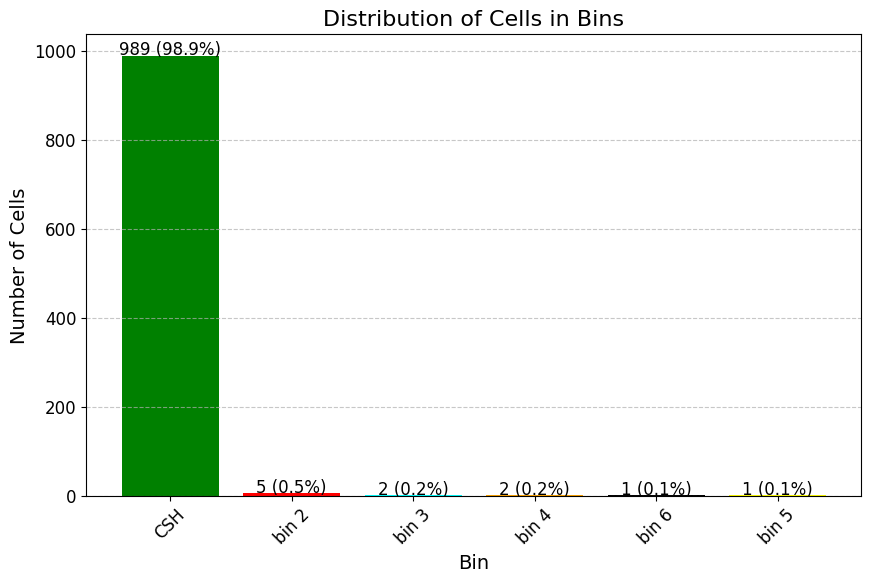

In [94]:
# Step 1: Define the same bin color mapping from UMAP
bin_colors = {
    "bin 1": "blue",
    "bin 2": "red",
    "bin 3": "cyan",
    "bin 4": "orange",
    "bin 5": "yellow",
    "bin 6": "black",
    "CSH": "green"
}

# Step 2: Count occurrences of each bin
bin_counts = filtered_df["Bin"].value_counts()

# Step 3: Compute percentages
total_cells = len(filtered_df)
bin_percentages = (bin_counts / total_cells) * 100

# Step 4: Print results
print(f"Total number of final_df entries: {total_cells}\n")
print("Cell Counts per Bin:")
print(bin_counts)
print("\nCell Percentages per Bin:")
print(bin_percentages)

# Step 5: Plot bar chart with UMAP colors
plt.figure(figsize=(10, 6))
bars = plt.bar(bin_counts.index, bin_counts.values, 
               color=[bin_colors[bin] for bin in bin_counts.index])

# Step 6: Add labels on top of bars (count + percentage)
for bar, count, percentage in zip(bars, bin_counts.values, bin_percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f"{count} ({percentage:.1f}%)", 
             ha="center", fontsize=12)

# Formatting
plt.xlabel("Bin", fontsize=14)
plt.ylabel("Number of Cells", fontsize=14)
plt.title("Distribution of Cells in Bins", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Step 7: Save the plot
output_path = "./active_learning_output_files/bin_distribution.png"
#plt.savefig(output_path, dpi=300, bbox_inches="tight")

# Show plot
plt.show()

Saved CSH cell images from filtered_df to ./active_learning_output_files/csh_images_filtered.png


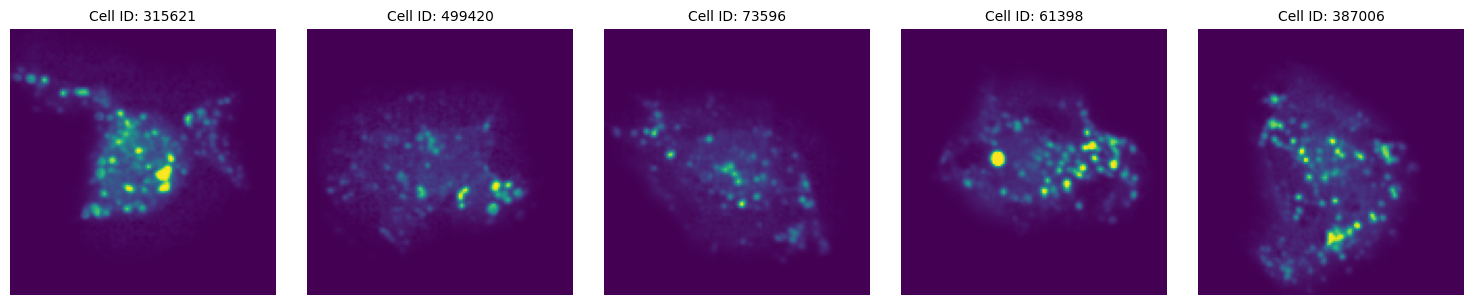

In [95]:
# Assuming filtered_df is already created from the previous steps
visualize_csh_images_from_filtered_df(filtered_df, test_data_loader)

In [96]:
# Get list of bins excluding "other"
valid_bins = ["bin 1", "bin 2", "bin 3", "bin 4", "bin 5", "bin 6"]

# Filter for rows where "Bin" is in valid_bins
filtered_bin_cells = filtered_df[filtered_df["Bin"].isin(valid_bins)]

# Extract the Cell IDs as a list
filtered_bin_cell_ids = filtered_bin_cells["Cell ID"].tolist()

# Print first few to check
print(filtered_bin_cell_ids[:10]) 
print(f"Total cells in bins 1-6, thus excised cells: {len(filtered_bin_cell_ids)}")

['409351', '498057', '435463', '5591', '148351', '377055', '130814', '444833', '437171', '445695']
Total cells in bins 1-6, thus excised cells: 11


In [99]:
# Subset filtered_df to create excised_df containing only cells in valid bins
excised_df = filtered_df[filtered_df["Cell ID"].isin(filtered_bin_cell_ids)]
#excised_df.head()

# Save excised_df to CSV
output_path = './active_learning_output_files/Orange_model_1_excised_cells.csv'
excised_df.to_csv(output_path, index=False)

# Print confirmation
print(f"Excised dataframe saved to {output_path}")

Excised dataframe saved to ./active_learning_output_files/Orange_model_1_excised_cells.csv
